## BQML - data prep

In [1]:
GCP_PROJECTS = !gcloud config get-value project
PROJECT_ID = GCP_PROJECTS[0]
PROJECT_NUM = !gcloud projects list --filter="$PROJECT_ID" --format="value(PROJECT_NUMBER)"
PROJECT_NUM = PROJECT_NUM[0]
LOCATION = 'us-central1'
REGION = "us-central1"

# VERTEX_SA = '934903580331-compute@developer.gserviceaccount.com'
VERTEX_SA = 'jt-vertex-sa@hybrid-vertex.iam.gserviceaccount.com'

print(f"PROJECT_ID: {PROJECT_ID}")
print(f"PROJECT_NUM: {PROJECT_NUM}")
print(f"LOCATION: {LOCATION}")
print(f"REGION: {REGION}")
print(f"VERTEX_SA: {VERTEX_SA}")

PROJECT_ID: hybrid-vertex
PROJECT_NUM: 934903580331
LOCATION: us-central1
REGION: us-central1
VERTEX_SA: jt-vertex-sa@hybrid-vertex.iam.gserviceaccount.com


In [2]:
REGION = 'us-central1'
EXPERIMENT = 'control_group1'
SERIES = 'causal_impact_1'

BQ_PROJECT = PROJECT_ID
BQ_DATASET = SERIES.replace('-','_')
BQ_TABLE = EXPERIMENT

BQ_SOURCE1 = 'bigquery-public-data.new_york.citibike_trips'
BQ_SOURCE2 = 'bigquery-public-data.new_york.citibike_stations'
viz_limit = 12

### packages

In [3]:
from google.cloud import bigquery

import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime, timedelta

from google.cloud import aiplatform as vertex_ai

### clients

In [4]:
bq_client = bigquery.Client(project=PROJECT_ID)

vertex_ai.init(
    project=PROJECT_ID, 
    location=REGION,
    # credentials=credentials
)

## Dataset

In [5]:
ds = bigquery.Dataset(f"{PROJECT_ID}.{BQ_DATASET}")
ds.location = 'us' #REGION
ds.labels = {'notebook': f"{EXPERIMENT}"}
ds = bq_client.create_dataset(dataset = ds, exists_ok = True)

In [6]:
ds.dataset_id

'causal_impact_1'

In [7]:
ds.full_dataset_id

'hybrid-vertex:causal_impact_1'

In [8]:
# datasets = list(bq_client.list_datasets())
# for d in datasets:
#     print(d.dataset_id)

In [9]:
query = f"""
    SELECT * 
    FROM `{BQ_SOURCE1}`
    LIMIT 5
"""
bq_client.query(query).to_dataframe()

tripduration                 starttime                  stoptime  \
0           107 2014-06-06 13:02:01+00:00 2014-06-06 13:03:48+00:00   
1          1105 2013-08-24 17:03:52+00:00 2013-08-24 17:22:17+00:00   
2           990 2014-04-25 11:52:28+00:00 2014-04-25 12:08:58+00:00   
3           138 2015-08-20 16:58:57+00:00 2015-08-20 17:01:16+00:00   
4            78 2014-09-13 13:18:36+00:00 2014-09-13 13:19:54+00:00   

   start_station_id start_station_name  start_station_latitude  \
0               520    W 52 St & 5 Ave               40.759923   
1               520    W 52 St & 5 Ave               40.759923   
2               520    W 52 St & 5 Ave               40.759923   
3               520    W 52 St & 5 Ave               40.759923   
4               520    W 52 St & 5 Ave               40.759923   

   start_station_longitude  end_station_id end_station_name  \
0               -73.976485             520  W 52 St & 5 Ave   
1               -73.976485             520  W 52 St & 5 Ave   
2               -73.976485             520  W 52 St & 5 Ave   
3               -73.976485             520  W 52 St & 5 Ave   
4               -73.976485             520  W 52 St & 5 Ave   

   end_station_latitude  end_station_longitude  bikeid    usertype  \
0             40.759923             -73.976485   16692  Subscriber   
1             40.759923             -73.976485   15352    Customer   
2             40.759923             -73.976485   20194  Subscriber   
3             40.759923             -73.976485   21002  Subscriber   
4             40.759923             -73.976485   19259    Customer   

   birth_year   gender  
0        1977     male  
1        <NA>  unknown  
2        1973     male  
3        1977     male  
4        <NA>  unknown

In [10]:
query = f"""
    SELECT * 
    FROM `{BQ_SOURCE2}`
    LIMIT 5
"""
bq_client.query(query).to_dataframe()

station_id                        name short_name   latitude  longitude  \
0        495            W 47 St & 10 Ave    6824.07  40.762699 -73.993012   
1       3171     Amsterdam Ave & W 82 St    7360.10  40.785247 -73.976673   
2       3603              31 Ave & 30 St    6857.09  40.764700 -73.924031   
3       3733          Avenue C & E 18 St    5769.04  40.730563 -73.973984   
4       3792  Columbus Dr at Exchange Pl      JC106  40.716870 -74.032810   

   region_id   rental_methods  capacity  eightd_has_key_dispenser  \
0         71  KEY, CREDITCARD         0                     False   
1         71  KEY, CREDITCARD         0                     False   
2         71  KEY, CREDITCARD         0                     False   
3         71  KEY, CREDITCARD         0                     False   
4         70  KEY, CREDITCARD         0                     False   

   num_bikes_available  num_bikes_disabled  num_docks_available  \
0                    0                   0                    0   
1                    0                   0                    0   
2                    0                   0                    0   
3                    0                   0                    0   
4                    0                   0                    0   

   num_docks_disabled  is_installed  is_renting  is_returning  \
0                   0          True        True          True   
1                   0         False       False         False   
2                   0         False       False         False   
3                   0         False       False         False   
4                   0         False       False         False   

   eightd_has_available_keys             last_reported  
0                      False 1970-01-02 00:00:00+00:00  
1                      False 1970-01-02 00:00:00+00:00  
2                      False 1970-01-02 00:00:00+00:00  
3                      False 1970-01-02 00:00:00+00:00  
4                      False 1970-01-02 00:00:00+00:00

## Control Group 1

In [11]:
station="Central Park"

In [12]:
# CUSTOMIZE
query = f"""
CREATE OR REPLACE TABLE `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_source` AS
WITH
    STATION AS (
        SELECT
           start_station_name,
           EXTRACT(DATE FROM starttime) AS starttime,
           COUNT(*) AS num_trips,
           AVG(tripduration) as avg_tripduration,
           COUNTIF(usertype='Subscriber')/COUNT(*) as pct_subscriber,
           SAFE_DIVIDE(COUNTIF(gender='male'), COUNTIF(gender!='male')) as ratio_gender
        FROM `{BQ_SOURCE1}`
        WHERE start_station_name LIKE '%{station}%'
        GROUP BY start_station_name, starttime
    ),
    STATION_INFO AS (
        SELECT
            name,
            max(capacity) as capacity
        FROM `{BQ_SOURCE2}`
        WHERE name LIKE '%{station}%'
        GROUP BY name
    )
SELECT * EXCEPT(name)
FROM STATION A
LEFT OUTER JOIN STATION_INFO B
ON A.start_station_name = B.name
ORDER BY start_station_name, starttime
"""
job = bq_client.query(query = query)
job.result()
(job.ended-job.started).total_seconds()

4.014

### Review time series data

In [13]:
# CUSTOMIZE
TARGET_COLUMN = 'num_trips'
TIME_COLUMN = 'starttime'
SERIES_COLUMN = 'start_station_name'
COVARIATE_COLUMNS = ['avg_tripduration', 'pct_subscriber', 'ratio_gender', 'capacity'] # could be empty

In [14]:
query = f"""
    SELECT {SERIES_COLUMN}, sum({TARGET_COLUMN}) as {TARGET_COLUMN}, min({TIME_COLUMN}) as FromDate, max({TIME_COLUMN}) as ToDate
    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_source`
    GROUP BY {SERIES_COLUMN}
    ORDER BY {SERIES_COLUMN}
"""
overview = bq_client.query(query).to_dataframe()
overview.head(viz_limit)

start_station_name  num_trips    FromDate  \
0   Central Park North & Adam Clayton Powell Blvd       4808  2016-09-01   
1                          Central Park S & 6 Ave     172220  2013-07-01   
2                        Central Park W & W 96 St       5905  2016-08-04   
3                    Central Park West & W 100 St       2245  2016-08-08   
4                    Central Park West & W 102 St       2851  2016-08-08   
5                     Central Park West & W 68 St      35192  2015-09-01   
6                     Central Park West & W 72 St      44574  2015-09-01   
7                     Central Park West & W 76 St      27919  2015-09-09   
8                     Central Park West & W 85 St      43895  2015-10-07   
9               Grand Army Plaza & Central Park S     163815  2013-07-01   
10                   W 106 St & Central Park West       4076  2016-08-11   
11                    W 82 St & Central Park West      18216  2015-09-29   

        ToDate  
0   2016-09-30  
1   2016-09-30  
2   2016-09-30  
3   2016-09-30  
4   2016-09-30  
5   2016-09-30  
6   2016-09-30  
7   2016-09-30  
8   2016-09-23  
9   2016-09-30  
10  2016-09-30  
11  2016-09-30

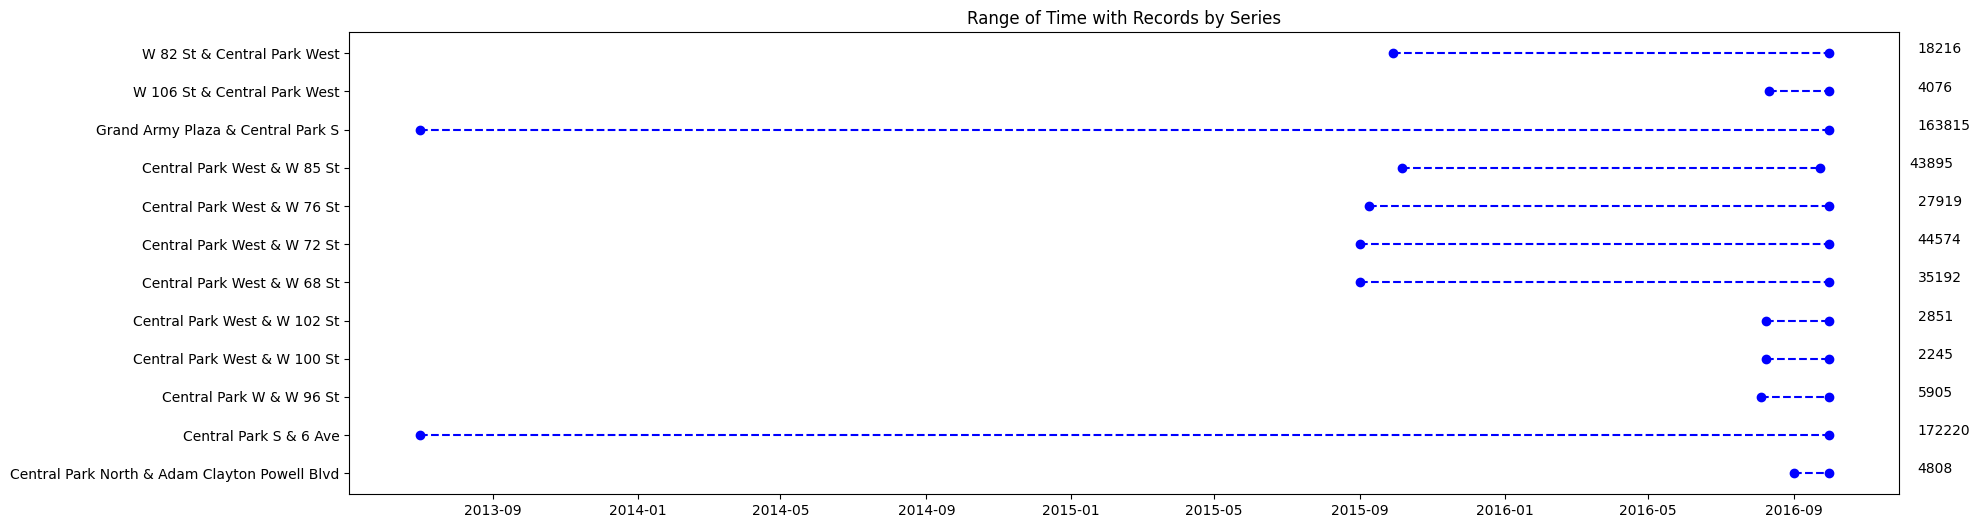

In [15]:
plt.figure(figsize=(20,6))
for i in range(viz_limit):
    x = [overview['FromDate'][i], overview['ToDate'][i]]
    y = [overview[SERIES_COLUMN][i], overview[SERIES_COLUMN][i]]
    plt.plot(x, y, 'bo', linestyle="--")
    plt.text(x[1]+timedelta(75), y[0], str(overview[TARGET_COLUMN][i]))
    plt.title('Range of Time with Records by Series')
plt.show()

In [16]:
query = f"""
    SELECT DISTINCT {SERIES_COLUMN}, {TIME_COLUMN}
    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_source`
"""
dates = bq_client.query(query).to_dataframe()

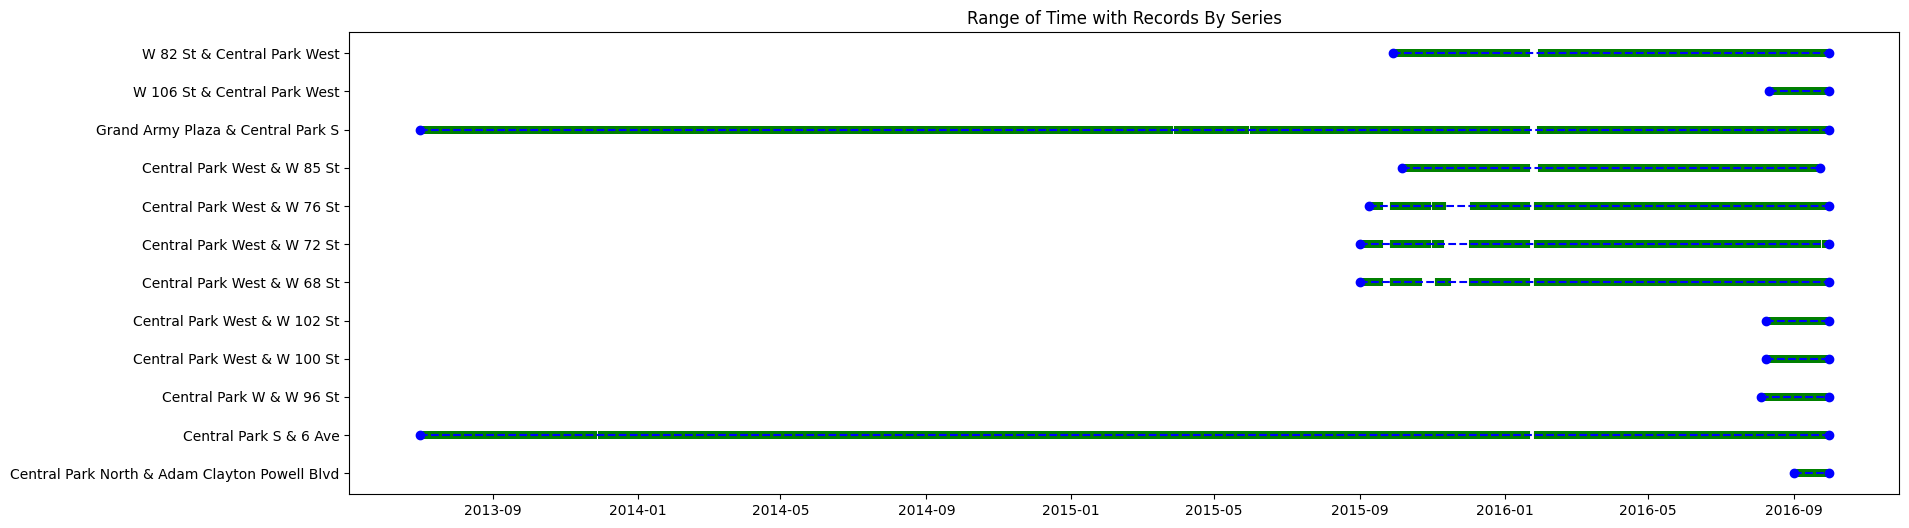

In [17]:
plt.figure(figsize=(20,6))
for i in range(viz_limit):
    x = [overview['FromDate'][i], overview['ToDate'][i]]
    y = [overview[SERIES_COLUMN][i], overview[SERIES_COLUMN][i]]
    plt.plot(x, y, 'bo', linestyle="--")
    # subset dates to current series and plot dates with records on timelines for each series:
    tempdates = dates[(dates[SERIES_COLUMN] == overview[SERIES_COLUMN][i])]
    plt.scatter(tempdates[TIME_COLUMN], tempdates[SERIES_COLUMN], c='g', marker='|')
    plt.title('Range of Time with Records By Series')
plt.show()

### train/test/valid splits

In [18]:
# CUSTOMIZE
forecast_granularity = 'DAY'
forecast_horizon = 14
forecast_test_length = 14
forecast_val_length = 14

In [19]:
query = f"""
    SELECT 
        MIN({TIME_COLUMN}) as start_date,
        DATE_SUB(MAX({TIME_COLUMN}), INTERVAL {forecast_test_length+forecast_val_length}-1 DAY) as val_start,
        DATE_SUB(MAX({TIME_COLUMN}), INTERVAL {forecast_test_length}-1 DAY) as test_start,
        MAX({TIME_COLUMN}) as end_date
    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_source`  
"""
keyDates = bq_client.query(query).to_dataframe()
keyDates

start_date   val_start  test_start    end_date
0  2013-07-01  2016-09-03  2016-09-17  2016-09-30

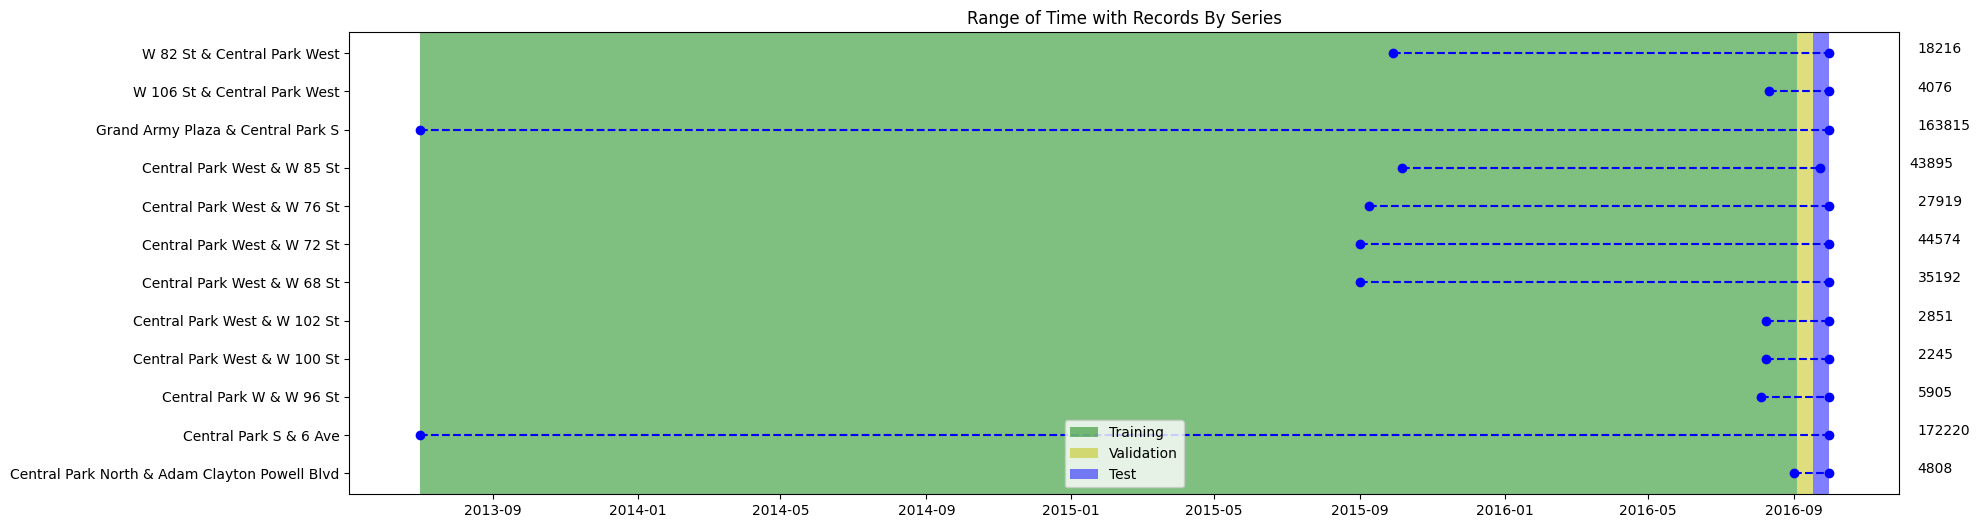

In [20]:
plt.figure(figsize=(20,6))
for i in range(viz_limit):
    x = [overview['FromDate'][i], overview['ToDate'][i]]
    y = [overview[SERIES_COLUMN][i], overview[SERIES_COLUMN][i]]
    plt.plot(x, y, 'bo', linestyle="--")
    plt.text(x[1]+timedelta(75), y[0], str(overview[TARGET_COLUMN][i]))
    plt.title('Range of Time with Records By Series')
plt.axvspan(keyDates['start_date'][0], keyDates['val_start'][0], facecolor='g', alpha = 0.5, label = 'Training')
plt.axvspan(keyDates['val_start'][0], keyDates['test_start'][0], facecolor='y', alpha = 0.5, label = 'Validation')
plt.axvspan(keyDates['test_start'][0], keyDates['end_date'][0], facecolor='b', alpha = 0.5, label = 'Test')
plt.legend(loc = 'lower center')
plt.show()

## Create BigQuery Table for Forecasting

In [21]:
query = f"""
    CREATE OR REPLACE TABLE `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_prepped` AS
    SELECT *,
       CASE
           WHEN {TIME_COLUMN} > DATE_SUB((SELECT MAX({TIME_COLUMN}) FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_source`), INTERVAL {forecast_test_length} {forecast_granularity}) THEN "TEST"
           WHEN {TIME_COLUMN} > DATE_SUB((SELECT MAX({TIME_COLUMN}) FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_source`), INTERVAL {forecast_test_length}+{forecast_val_length} {forecast_granularity}) THEN "VALIDATE"
           ELSE "TRAIN"
       END AS splits
    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_source`
"""
job = bq_client.query(query)
job.result()
(job.ended-job.started).total_seconds()

18.132

### review forecasting data

In [22]:
query = f"""
    SELECT 
        {SERIES_COLUMN},
        COUNTIF(splits='TRAIN') as TRAIN,
        COUNTIF(splits='VALIDATE') as VALIDATE,
        COUNTIF(splits='TEST') as TEST,
        sum({TARGET_COLUMN}) as {TARGET_COLUMN}
    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_prepped`
    GROUP BY {SERIES_COLUMN}
    ORDER BY {SERIES_COLUMN}
"""
splitCounts = bq_client.query(query).to_dataframe()
splitCounts.head(viz_limit)

start_station_name  TRAIN  VALIDATE  TEST  \
0   Central Park North & Adam Clayton Powell Blvd      2        14    14   
1                          Central Park S & 6 Ave   1149        14    14   
2                        Central Park W & W 96 St     30        14    14   
3                    Central Park West & W 100 St     26        14    14   
4                    Central Park West & W 102 St     26        14    14   
5                     Central Park West & W 68 St    331        14    14   
6                     Central Park West & W 72 St    334        14    13   
7                     Central Park West & W 76 St    327        14    14   
8                     Central Park West & W 85 St    324        14     7   
9               Grand Army Plaza & Central Park S   1152        14    13   
10                   W 106 St & Central Park West     23        14    14   
11                    W 82 St & Central Park West    331        14    14   

    num_trips  
0        4808  
1      172220  
2        5905  
3        2245  
4        2851  
5       35192  
6       44574  
7       27919  
8       43895  
9      163815  
10       4076  
11      18216

In [23]:
splitCounts[['TRAIN','VALIDATE','TEST']].sum()

TRAIN       4055
VALIDATE     168
TEST         159
dtype: int64

In [24]:
splitCounts[['TRAIN','VALIDATE','TEST']].sum().sum()

4382

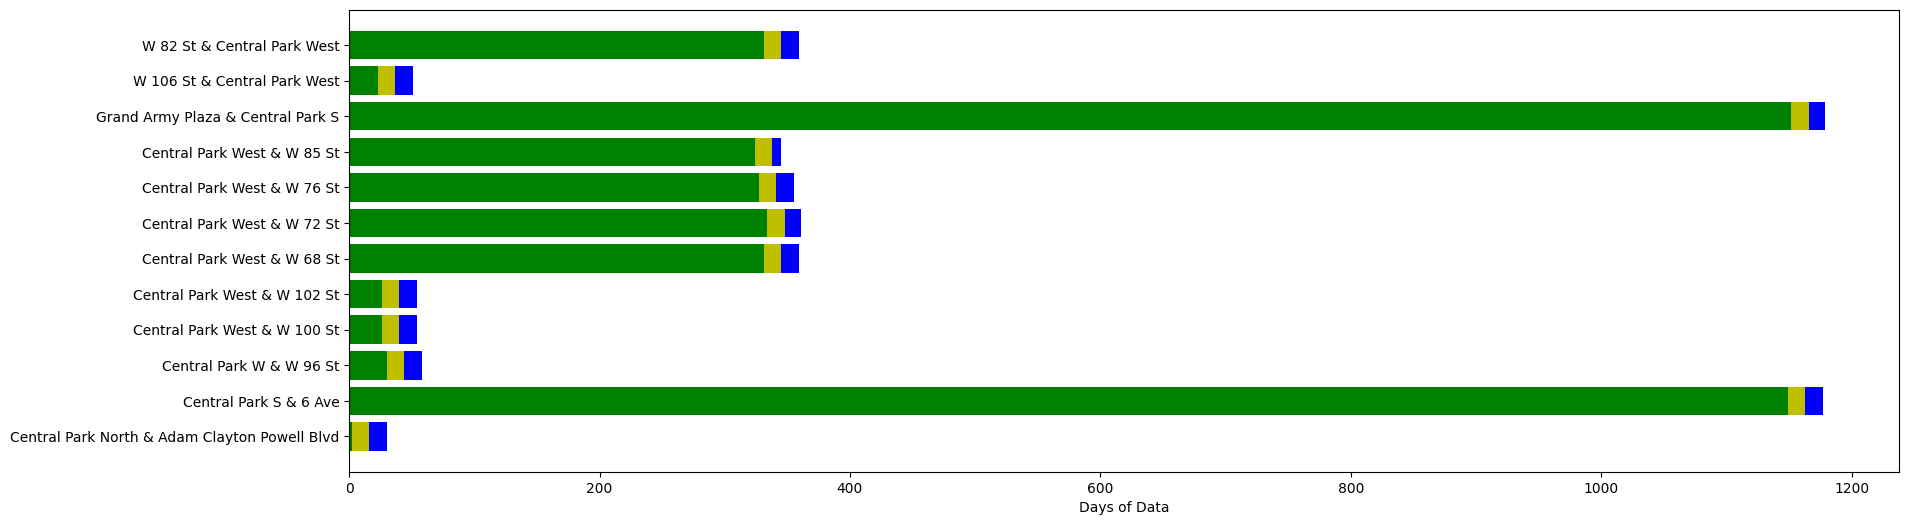

In [25]:
tempsplitCounts = splitCounts.iloc[0:viz_limit]
plt.figure(figsize=(20,6))
plt.barh(tempsplitCounts[SERIES_COLUMN], tempsplitCounts['TRAIN'], color = 'g')
plt.barh(tempsplitCounts[SERIES_COLUMN], tempsplitCounts['VALIDATE'], color = 'y', left = tempsplitCounts['TRAIN'])
plt.barh(tempsplitCounts[SERIES_COLUMN], tempsplitCounts['TEST'], color = 'b', left = tempsplitCounts['TRAIN'] + tempsplitCounts['VALIDATE'])
plt.xlabel('Days of Data')
plt.show()

### Validation Check: Extract dates for splits from source


In [26]:
query = f"""
    WITH
        SPLIT AS (
            SELECT splits, min({TIME_COLUMN}) as mindate, max({TIME_COLUMN}) as maxdate
            FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_prepped`
            GROUP BY splits
        ),
        TRAIN AS (
            SELECT mindate as start_date
            FROM SPLIT
            WHERE splits ='TRAIN'
        ),
        VAL AS (
            SELECT mindate as val_start
            FROM SPLIT
            WHERE splits = 'VALIDATE'
        ),
        TEST AS (
            SELECT mindate as test_start, maxdate as end_date
            FROM SPLIT
            WHERE splits = 'TEST'
        )
    SELECT * EXCEPT(pos) FROM
    (SELECT *, ROW_NUMBER() OVER() pos FROM TRAIN)
    JOIN (SELECT *, ROW_NUMBER() OVER() pos FROM VAL)
    USING (pos)
    JOIN (SELECT *, ROW_NUMBER() OVER() pos FROM TEST)
    USING (pos)
"""
keyDates = bq_client.query(query).to_dataframe()
keyDates

start_date   val_start  test_start    end_date
0  2013-07-01  2016-09-03  2016-09-17  2016-09-30

### check for duplicates

In [27]:
query = f"""
    WITH
        DAYS AS (
            SELECT {SERIES_COLUMN}, {TIME_COLUMN}, count(*) as records
            FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_prepped`
            GROUP BY {SERIES_COLUMN}, {TIME_COLUMN}
        )
    SELECT *
    FROM DAYS
    WHERE records > 1
"""
bq_client.query(query).to_dataframe()

Empty DataFrame
Columns: [start_station_name, starttime, records]
Index: []

In [28]:
query = f"""
    SELECT 
        {SERIES_COLUMN}, {TIME_COLUMN}, {TARGET_COLUMN}, splits,
        {', '.join(COVARIATE_COLUMNS)}
    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_prepped`
    ORDER by {SERIES_COLUMN}, {TIME_COLUMN}
"""
rawSeries = bq_client.query(query).to_dataframe()

# plot time series

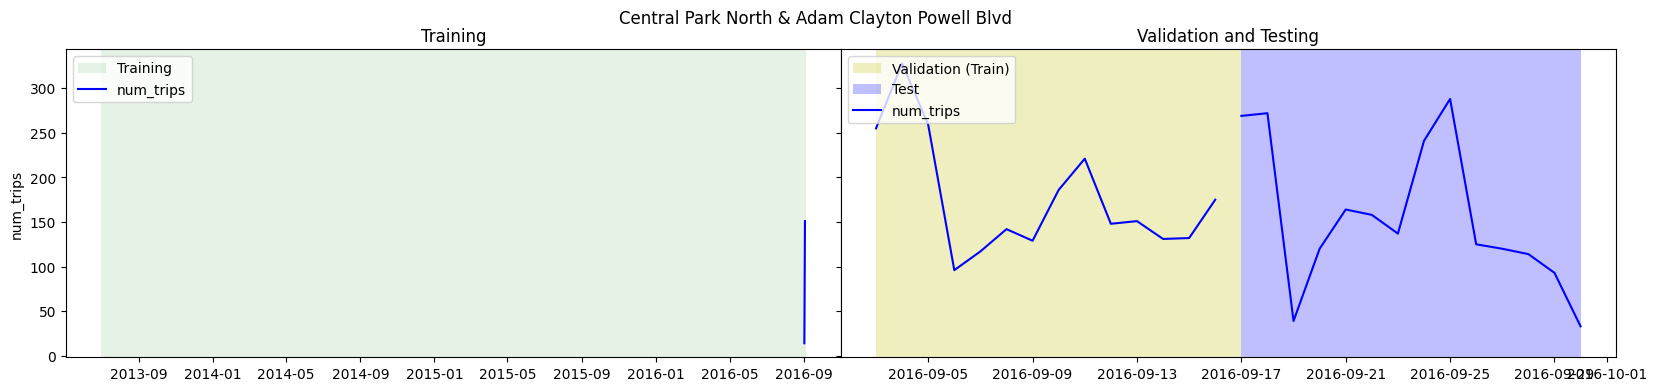

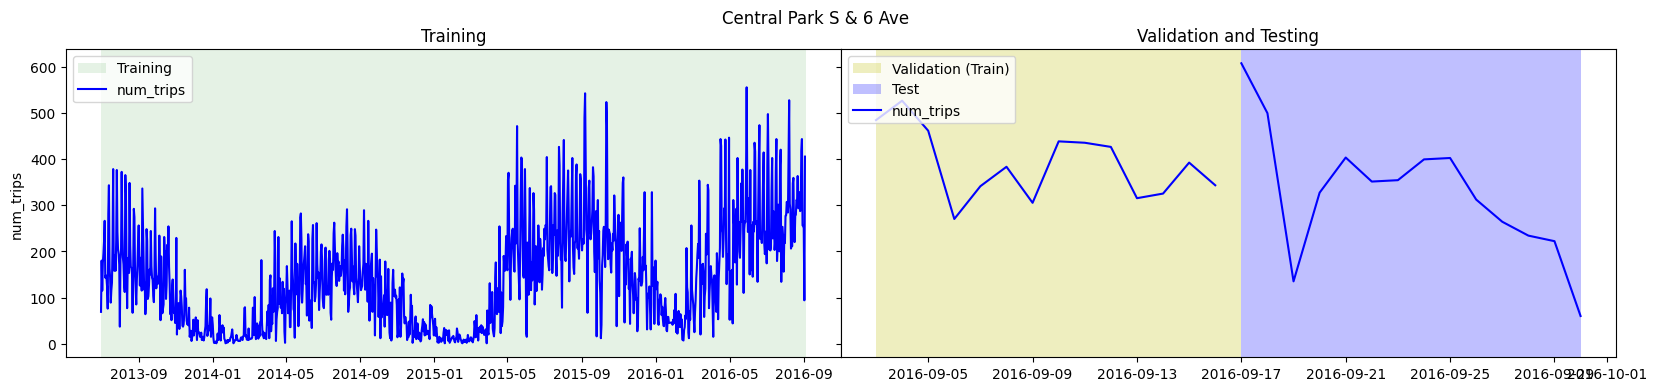

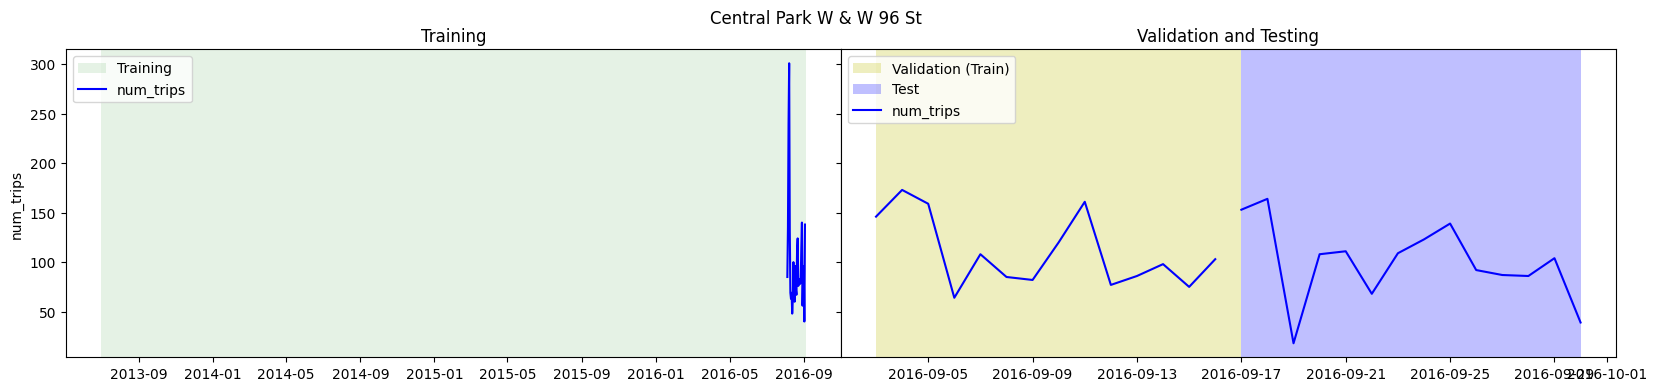

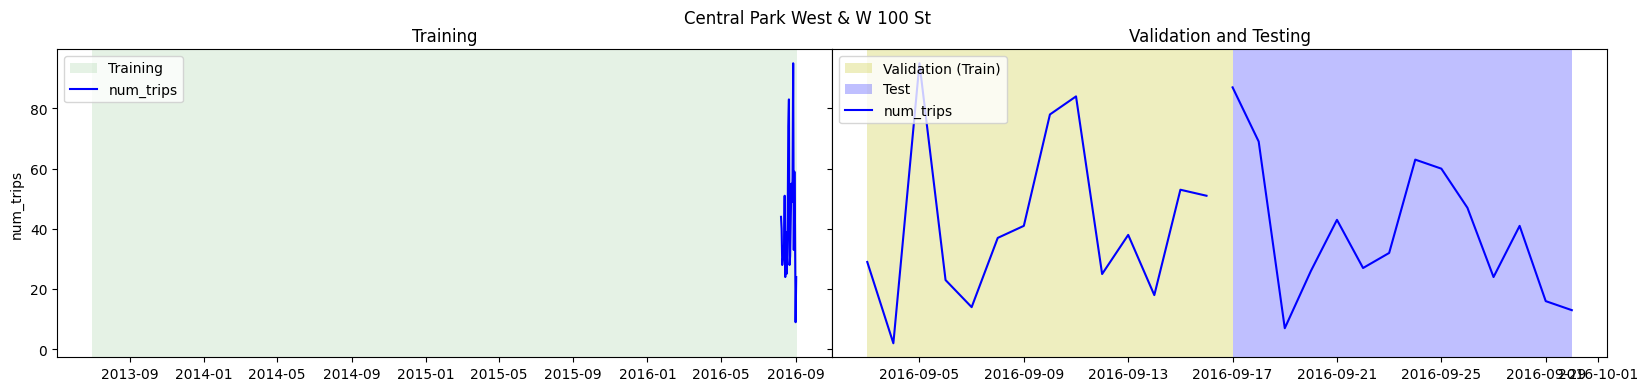

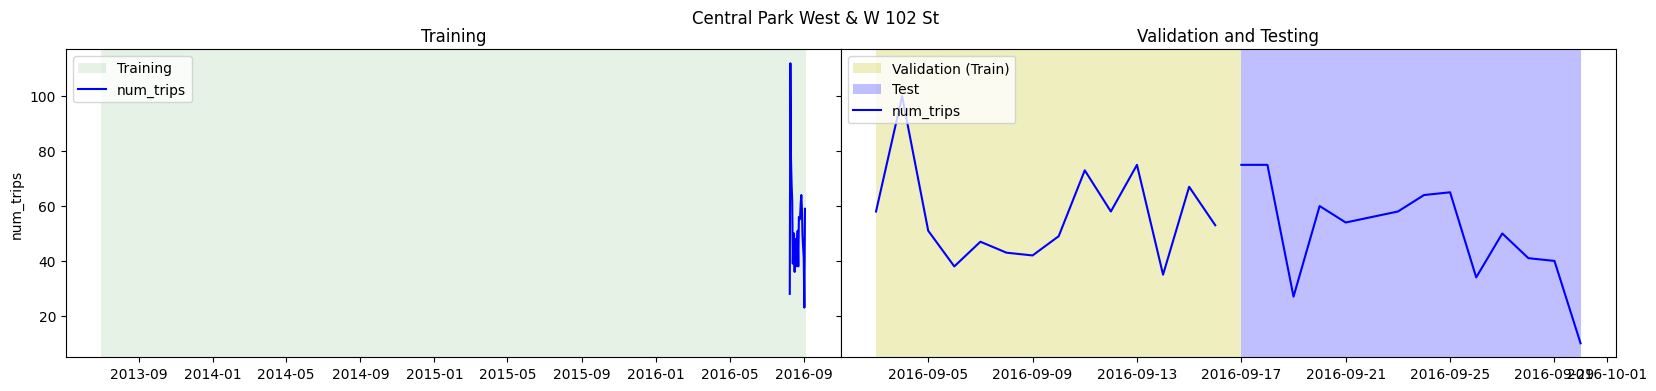

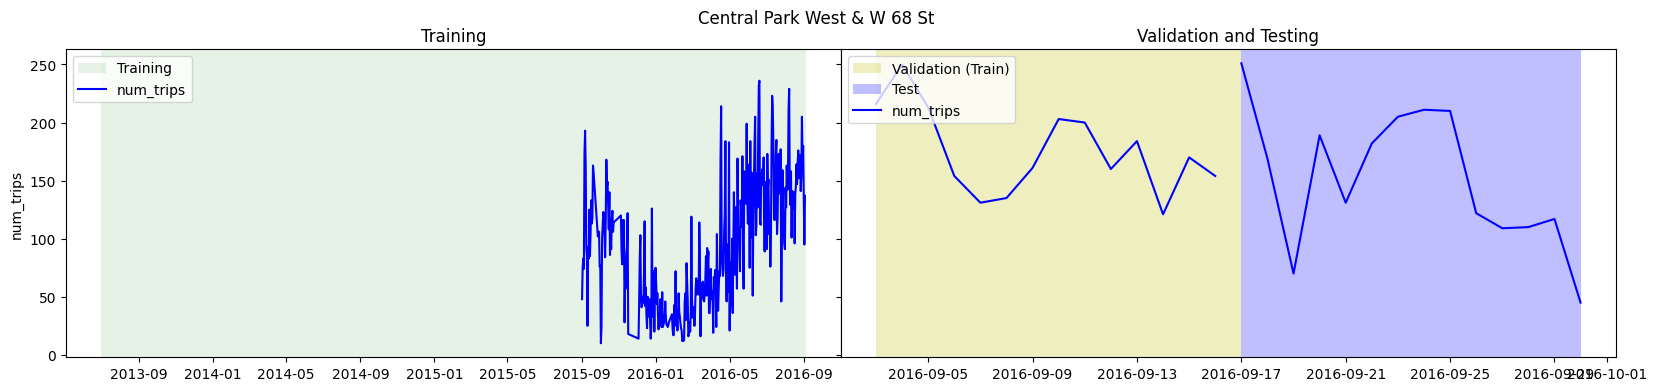

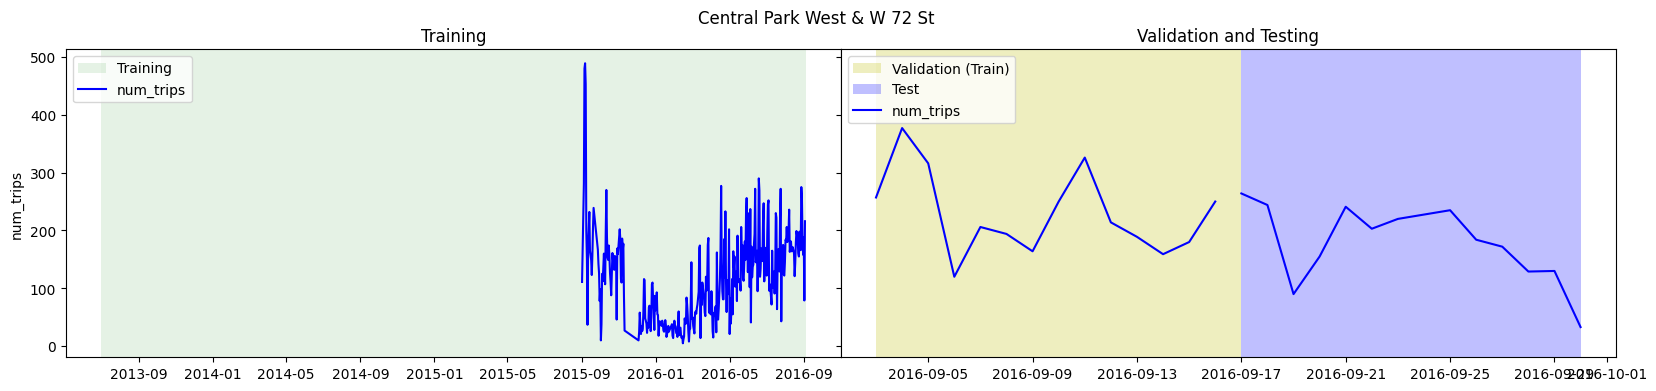

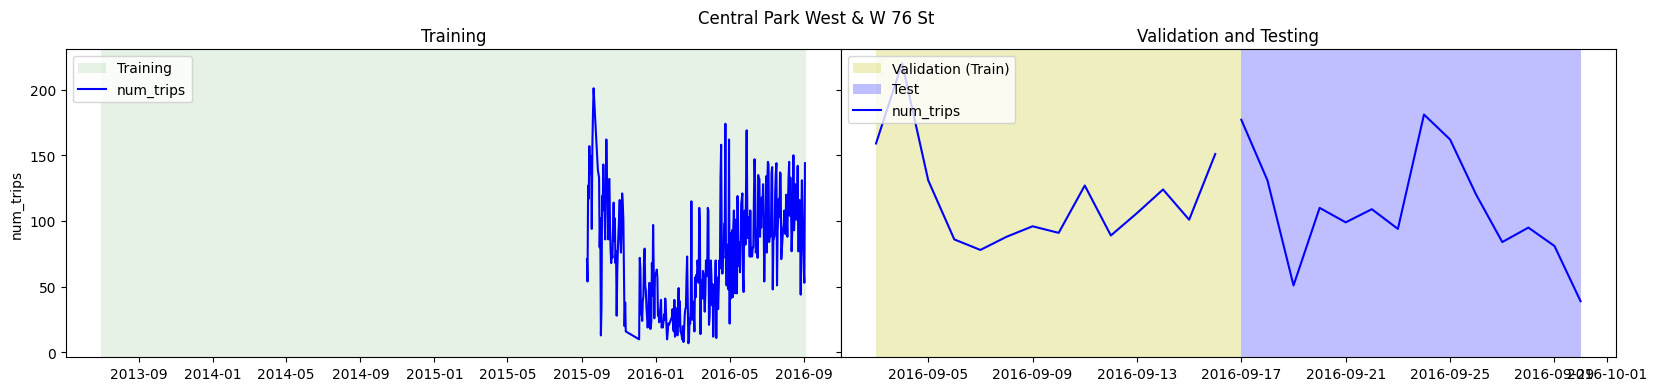

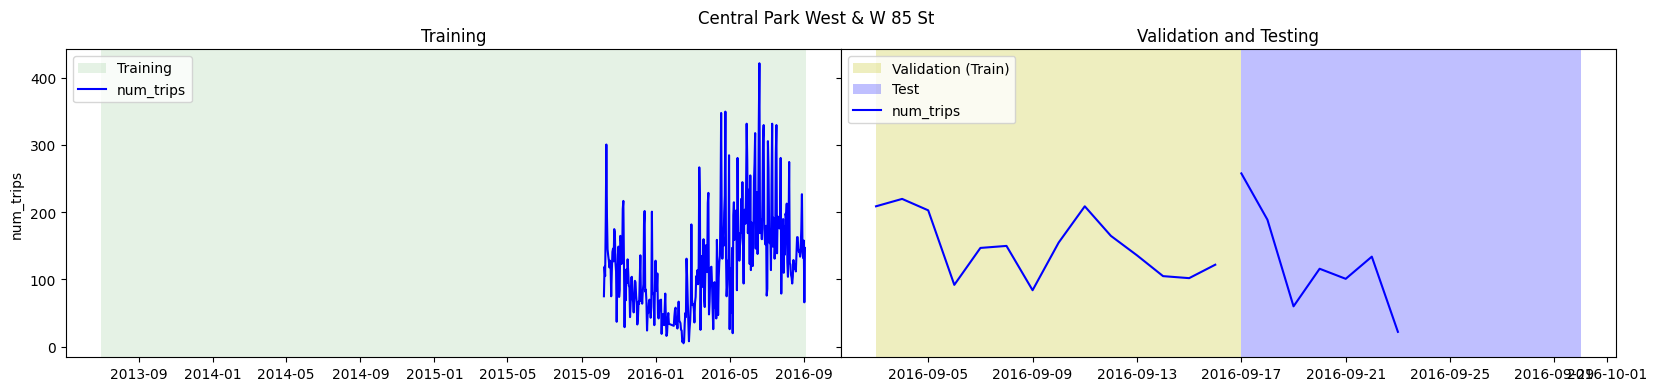

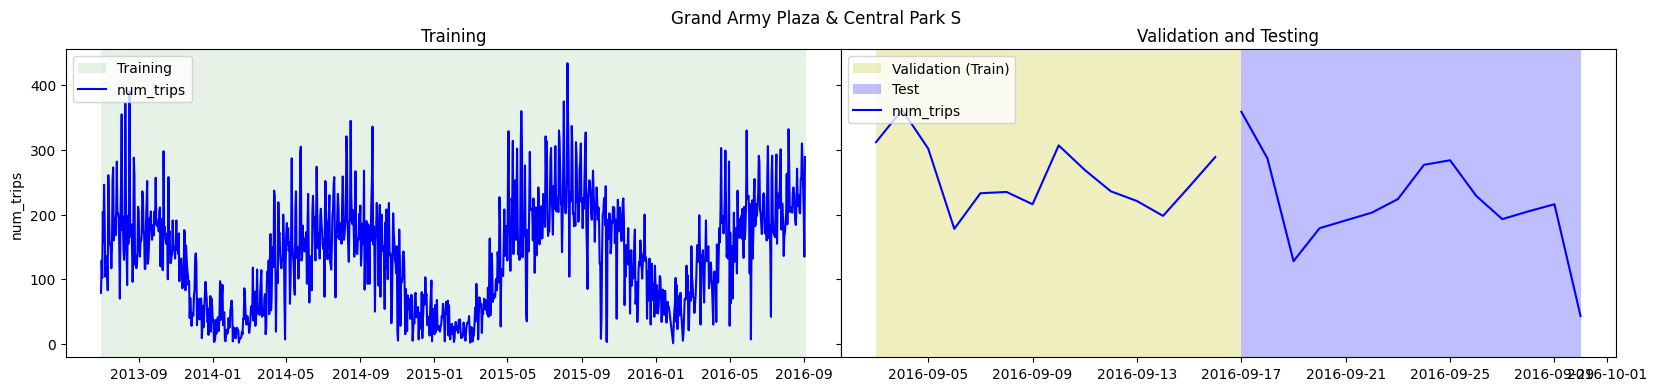

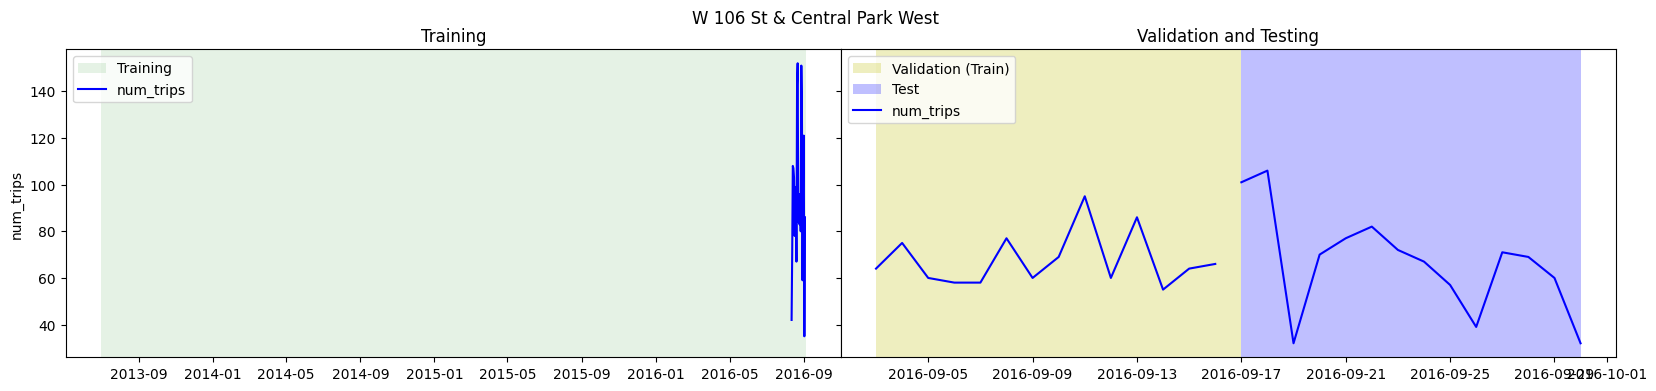

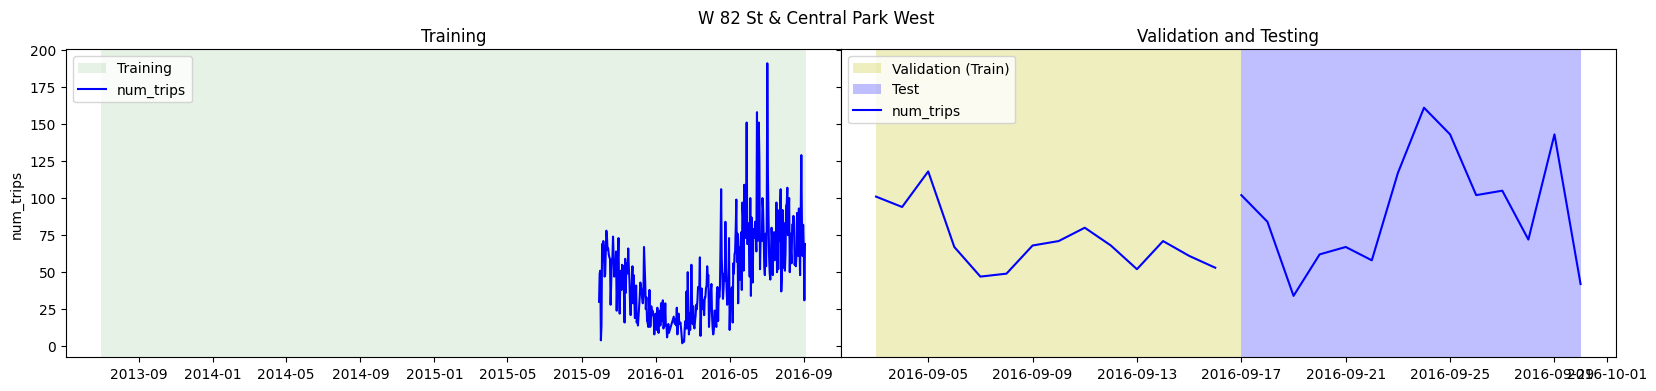

In [29]:
series = rawSeries[SERIES_COLUMN].unique().tolist()
for s, st in enumerate(series):
    if s <= viz_limit:
        # setup plot area
        fig, axes = plt.subplots(1, 2, figsize=(20, 4), sharex=False, sharey=True)
        fig.subplots_adjust(wspace=0)

        # data
        traindf = rawSeries[(rawSeries[SERIES_COLUMN] == st) & (rawSeries['splits'] == 'TRAIN')]
        valdf = rawSeries[(rawSeries[SERIES_COLUMN] == st) & (rawSeries['splits'] == 'VALIDATE')]
        testdf = rawSeries[(rawSeries[SERIES_COLUMN] == st) & (rawSeries['splits'] == 'TEST')]

        # regions
        axes[0].axvspan(keyDates['start_date'][0], keyDates['val_start'][0], facecolor='g', alpha = 0.1, label = 'Training')
        axes[1].axvspan(keyDates['val_start'][0], keyDates['test_start'][0], facecolor='y', alpha = 0.25, label = 'Validation (Train)')
        axes[1].axvspan(keyDates['test_start'][0], keyDates['end_date'][0], facecolor='b', alpha = 0.25, label = 'Test')

        # lines and dots
        axes[0].plot(traindf[TIME_COLUMN], traindf[TARGET_COLUMN], color = 'b', label = f'{TARGET_COLUMN}')
        axes[1].plot(valdf[TIME_COLUMN], valdf[TARGET_COLUMN], color = 'b', label = f'{TARGET_COLUMN}')
        axes[1].plot(testdf[TIME_COLUMN], testdf[TARGET_COLUMN], color = 'b')

        # labels
        axes[0].set_ylabel(TARGET_COLUMN)
        axes[0].set_title('Training')
        axes[1].set_title('Validation and Testing')
        axes[1].legend(loc = 'upper left')
        axes[0].legend(loc = 'upper left')
        plt.suptitle(st)

        # display result
        plt.show()

## overlay covariates

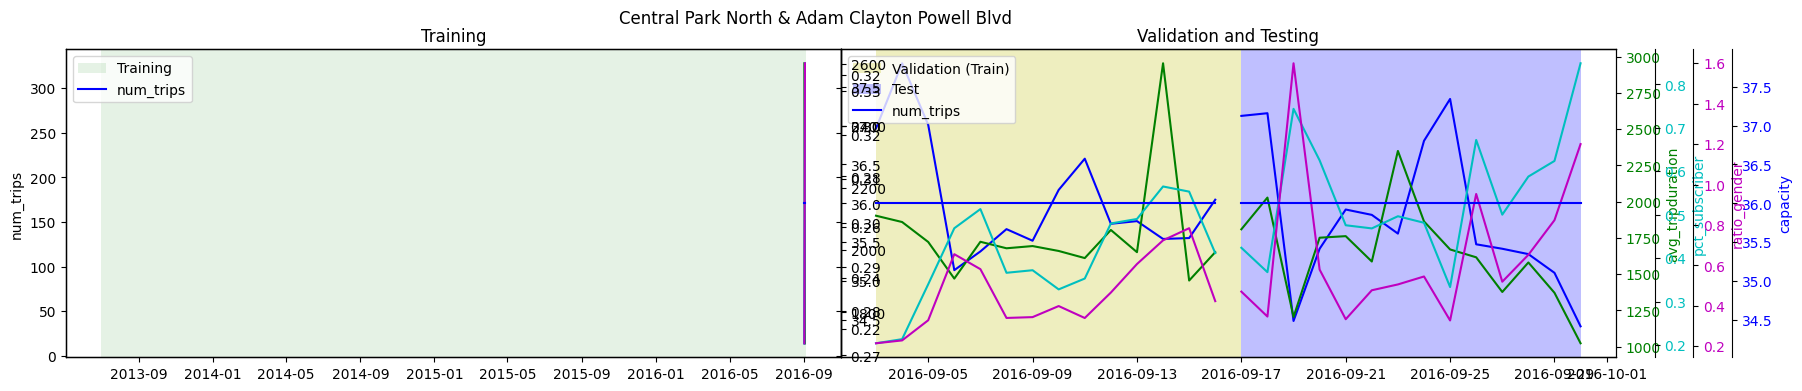

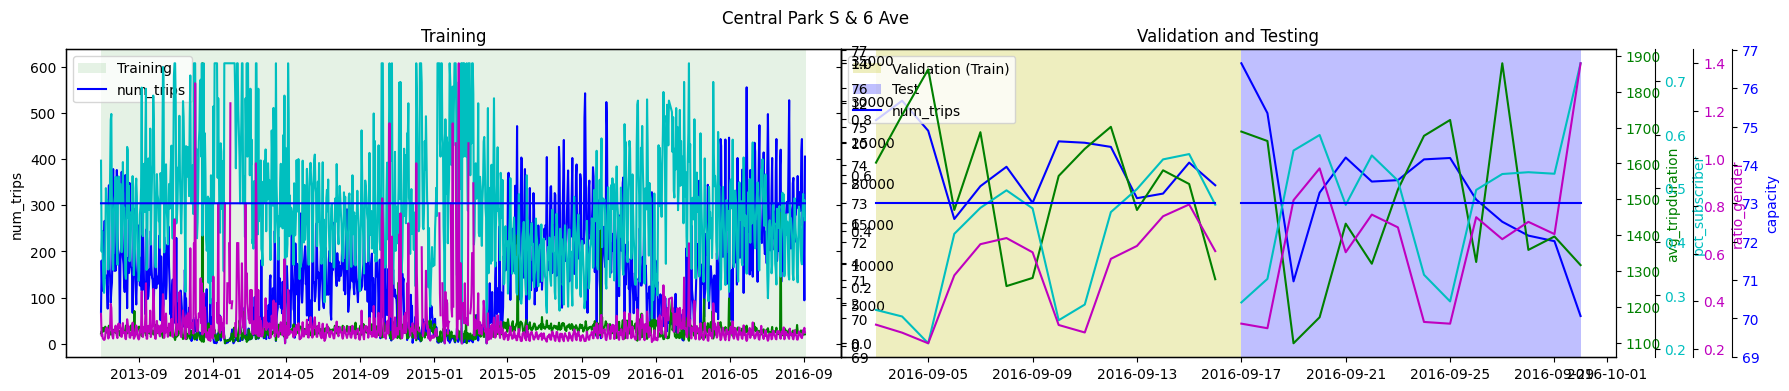

TypeError: float() argument must be a string or a number, not 'NAType'

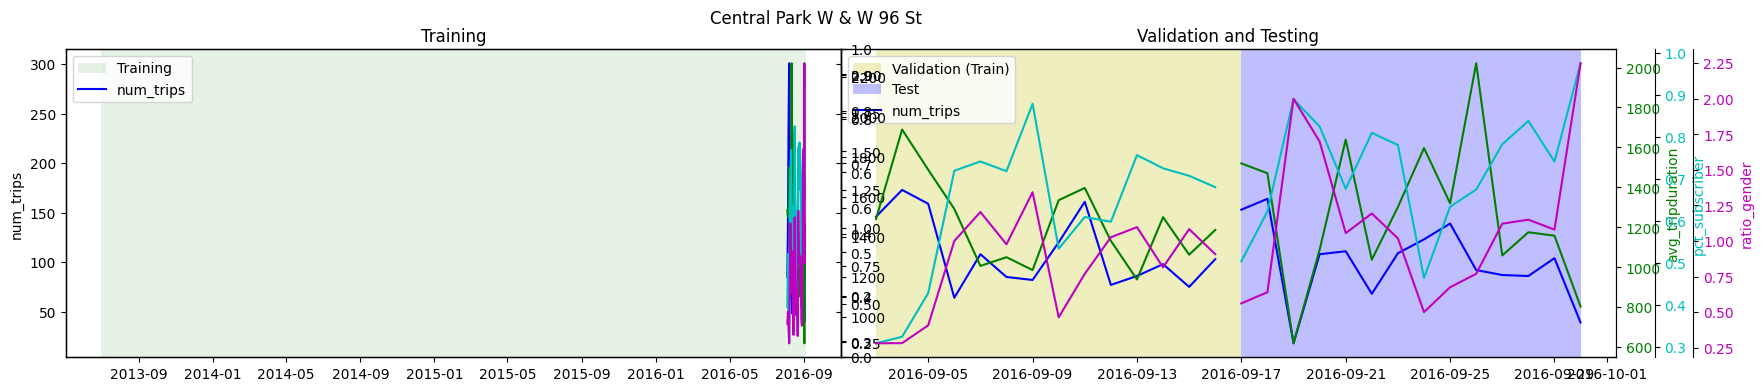

In [31]:
series = rawSeries[SERIES_COLUMN].unique().tolist()
for s, st in enumerate(series):
    if s <= viz_limit:
        # setup plot area
        fig, axes = plt.subplots(1, 2, figsize=(20, 4), sharex=False, sharey=True)
        fig.subplots_adjust(wspace=0)

        # data
        traindf = rawSeries[(rawSeries[SERIES_COLUMN] == st) & (rawSeries['splits'] == 'TRAIN')]
        valdf = rawSeries[(rawSeries[SERIES_COLUMN] == st) & (rawSeries['splits'] == 'VALIDATE')]
        testdf = rawSeries[(rawSeries[SERIES_COLUMN] == st) & (rawSeries['splits'] == 'TEST')]

        # regions
        axes[0].axvspan(keyDates['start_date'][0], keyDates['val_start'][0], facecolor='g', alpha = 0.1, label = 'Training')
        axes[1].axvspan(keyDates['val_start'][0], keyDates['test_start'][0], facecolor='y', alpha = 0.25, label = 'Validation (Train)')
        axes[1].axvspan(keyDates['test_start'][0], keyDates['end_date'][0], facecolor='b', alpha = 0.25, label = 'Test')

        # lines and dots
        axes[0].plot(traindf[TIME_COLUMN], traindf[TARGET_COLUMN], color = 'b', label = f'{TARGET_COLUMN}')
        axes[1].plot(valdf[TIME_COLUMN], valdf[TARGET_COLUMN], color = 'b', label = f'{TARGET_COLUMN}')
        axes[1].plot(testdf[TIME_COLUMN], testdf[TARGET_COLUMN], color = 'b')

        # labels
        axes[0].set_ylabel(TARGET_COLUMN)
        axes[0].set_title('Training')
        axes[1].set_title('Validation and Testing')
        axes[1].legend(loc = 'upper left')
        axes[0].legend(loc = 'upper left')
        plt.suptitle(st)

        # overaly covariates (up to 5):
        for c, cov in enumerate(COVARIATE_COLUMNS):
            colors = ['g','c','m','b','r']
            if c<5:
                
                twin = axes[0].twinx()
                twin.plot(traindf[TIME_COLUMN], traindf[cov], color = colors[c], label = f'{cov}')
                
                twin = axes[1].twinx()
                twin.set_ylabel(cov, color = colors[c])
                twin.tick_params(axis = 'y', labelcolor = colors[c])
                twin.spines.right.set_position(("axes", 1+.05*c))
                twin.plot(valdf[TIME_COLUMN], valdf[cov], color = colors[c], label = f'{cov}')
                twin.plot(testdf[TIME_COLUMN], testdf[cov], color = colors[c], label = f'{cov}')
        
        # display result
        plt.show()

## Control Group 2

In [51]:
# station="Pershing Square"
station="Broadway"

REGION = 'us-central1'
EXPERIMENT = 'control_group2'
BQ_TABLE = EXPERIMENT

SERIES = 'causal_impact_1'

viz_limit = 12

In [49]:
# CUSTOMIZE
query = f"""
CREATE OR REPLACE TABLE `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_source` AS
WITH
    STATION AS (
        SELECT
           start_station_name,
           EXTRACT(DATE FROM starttime) AS starttime,
           COUNT(*) AS num_trips,
           AVG(tripduration) as avg_tripduration,
           COUNTIF(usertype='Subscriber')/COUNT(*) as pct_subscriber,
           SAFE_DIVIDE(COUNTIF(gender='male'), COUNTIF(gender!='male')) as ratio_gender
        FROM `{BQ_SOURCE1}`
        WHERE start_station_name LIKE '%{station}%'
        GROUP BY start_station_name, starttime
    ),
    STATION_INFO AS (
        SELECT
            name,
            max(capacity) as capacity
        FROM `{BQ_SOURCE2}`
        WHERE name LIKE '%{station}%'
        GROUP BY name
    )
SELECT * EXCEPT(name)
FROM STATION A
LEFT OUTER JOIN STATION_INFO B
ON A.start_station_name = B.name
ORDER BY start_station_name, starttime
"""
job = bq_client.query(query = query)
job.result()
(job.ended-job.started).total_seconds()

2.417

## Review Time Series Data

In [52]:
query = f"""
    SELECT {SERIES_COLUMN}, sum({TARGET_COLUMN}) as {TARGET_COLUMN}, min({TIME_COLUMN}) as FromDate, max({TIME_COLUMN}) as ToDate
    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_source`
    GROUP BY {SERIES_COLUMN}
    ORDER BY {SERIES_COLUMN}
"""
overview = bq_client.query(query).to_dataframe()
overview.head(viz_limit)

start_station_name  num_trips    FromDate      ToDate
0     Boerum St & Broadway       4560  2015-08-20  2016-09-30
1    Broadway & Battery Pl     104126  2013-07-01  2016-09-30
2      Broadway & Berry St      32013  2013-07-01  2016-09-30
3       Broadway & E 14 St     244420  2013-07-01  2016-09-30
4       Broadway & E 22 St     237394  2013-07-01  2016-09-30
5   Broadway & Roebling St       8836  2015-11-06  2016-09-30
6       Broadway & W 24 St     211713  2013-07-01  2016-09-30
7       Broadway & W 29 St     132500  2013-07-01  2016-09-30
8       Broadway & W 32 St     138812  2013-07-01  2016-09-30
9       Broadway & W 36 St      76901  2013-07-01  2016-09-30
10      Broadway & W 37 St      75247  2013-07-01  2016-09-30
11      Broadway & W 39 St      94276  2013-07-01  2016-09-30

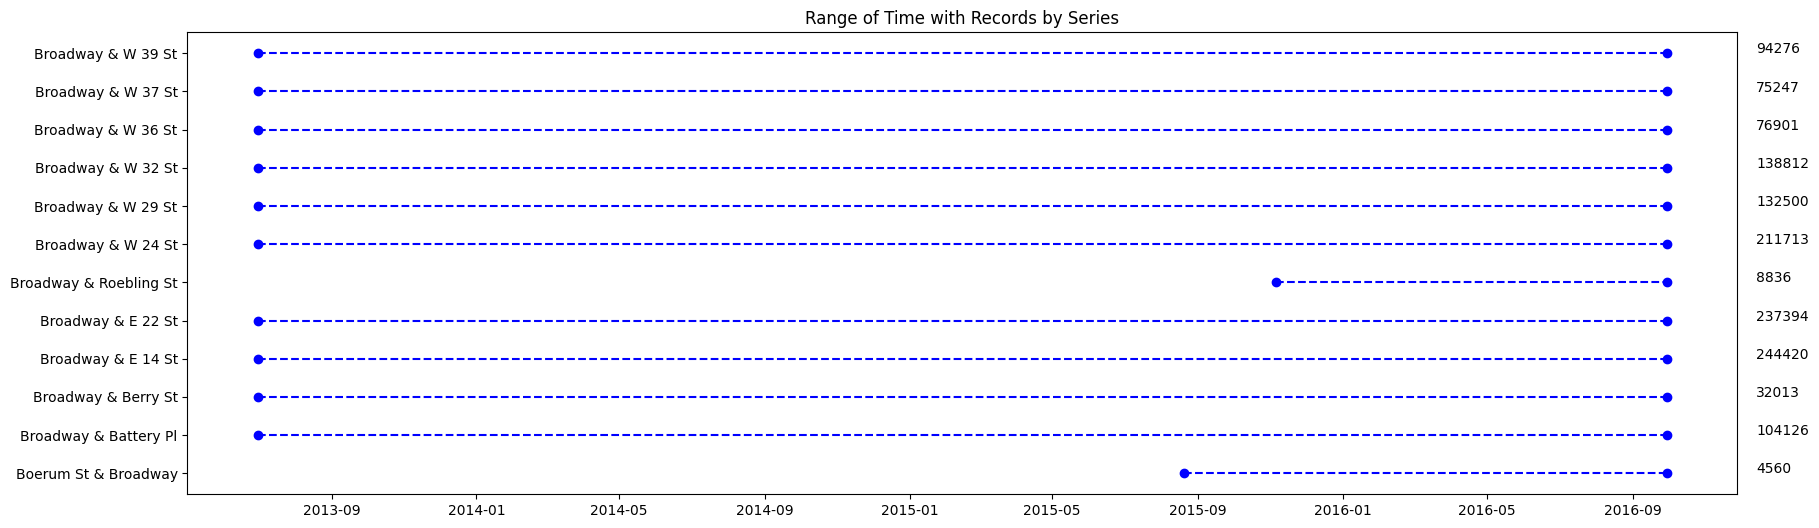

In [53]:
plt.figure(figsize=(20,6))
for i in range(viz_limit):
    x = [overview['FromDate'][i], overview['ToDate'][i]]
    y = [overview[SERIES_COLUMN][i], overview[SERIES_COLUMN][i]]
    plt.plot(x, y, 'bo', linestyle="--")
    plt.text(x[1]+timedelta(75), y[0], str(overview[TARGET_COLUMN][i]))
    plt.title('Range of Time with Records by Series')
plt.show()

In [54]:
query = f"""
    SELECT DISTINCT {SERIES_COLUMN}, {TIME_COLUMN}
    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_source`
"""
dates = bq_client.query(query).to_dataframe()

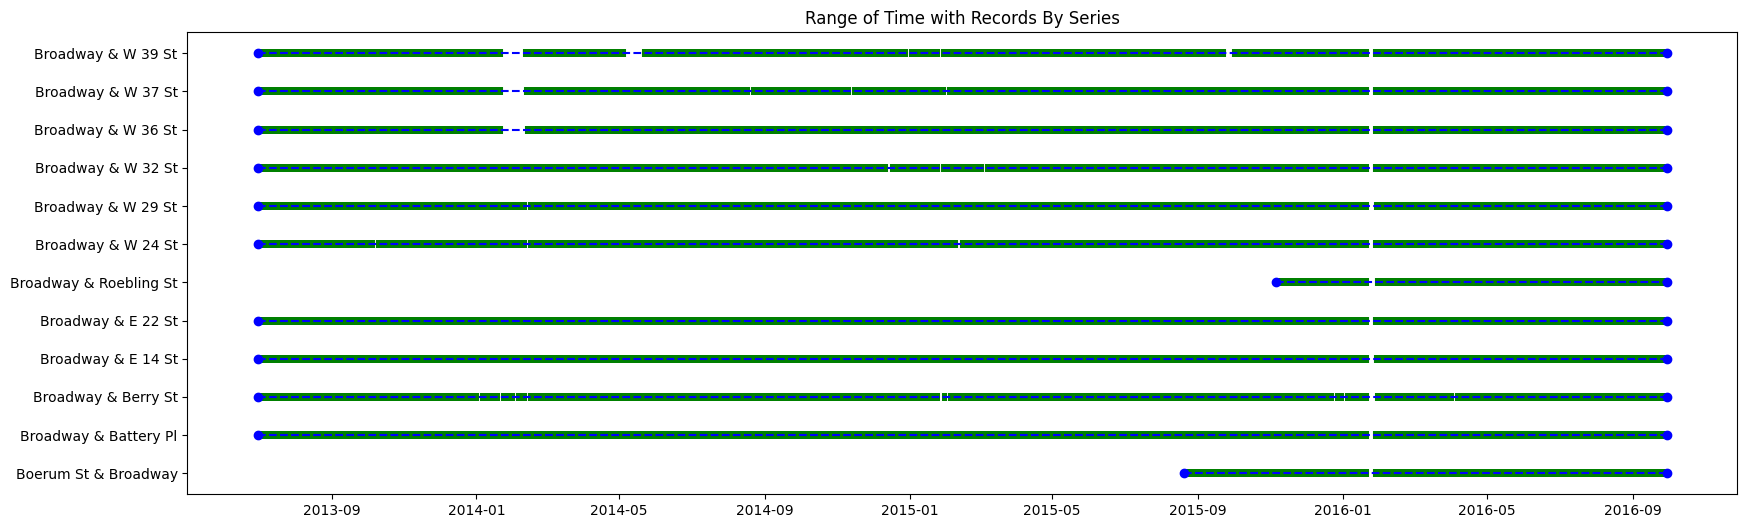

In [55]:
plt.figure(figsize=(20,6))
for i in range(viz_limit):
    x = [overview['FromDate'][i], overview['ToDate'][i]]
    y = [overview[SERIES_COLUMN][i], overview[SERIES_COLUMN][i]]
    plt.plot(x, y, 'bo', linestyle="--")
    # subset dates to current series and plot dates with records on timelines for each series:
    tempdates = dates[(dates[SERIES_COLUMN] == overview[SERIES_COLUMN][i])]
    plt.scatter(tempdates[TIME_COLUMN], tempdates[SERIES_COLUMN], c='g', marker='|')
    plt.title('Range of Time with Records By Series')
plt.show()

#### train/test/valid splits

In [56]:
# CUSTOMIZE
forecast_granularity = 'DAY'
forecast_horizon = 14
forecast_test_length = 14
forecast_val_length = 14

In [57]:
query = f"""
    SELECT 
        MIN({TIME_COLUMN}) as start_date,
        DATE_SUB(MAX({TIME_COLUMN}), INTERVAL {forecast_test_length+forecast_val_length}-1 DAY) as val_start,
        DATE_SUB(MAX({TIME_COLUMN}), INTERVAL {forecast_test_length}-1 DAY) as test_start,
        MAX({TIME_COLUMN}) as end_date
    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_source`  
"""
keyDates = bq_client.query(query).to_dataframe()
keyDates

start_date   val_start  test_start    end_date
0  2013-07-01  2016-09-03  2016-09-17  2016-09-30

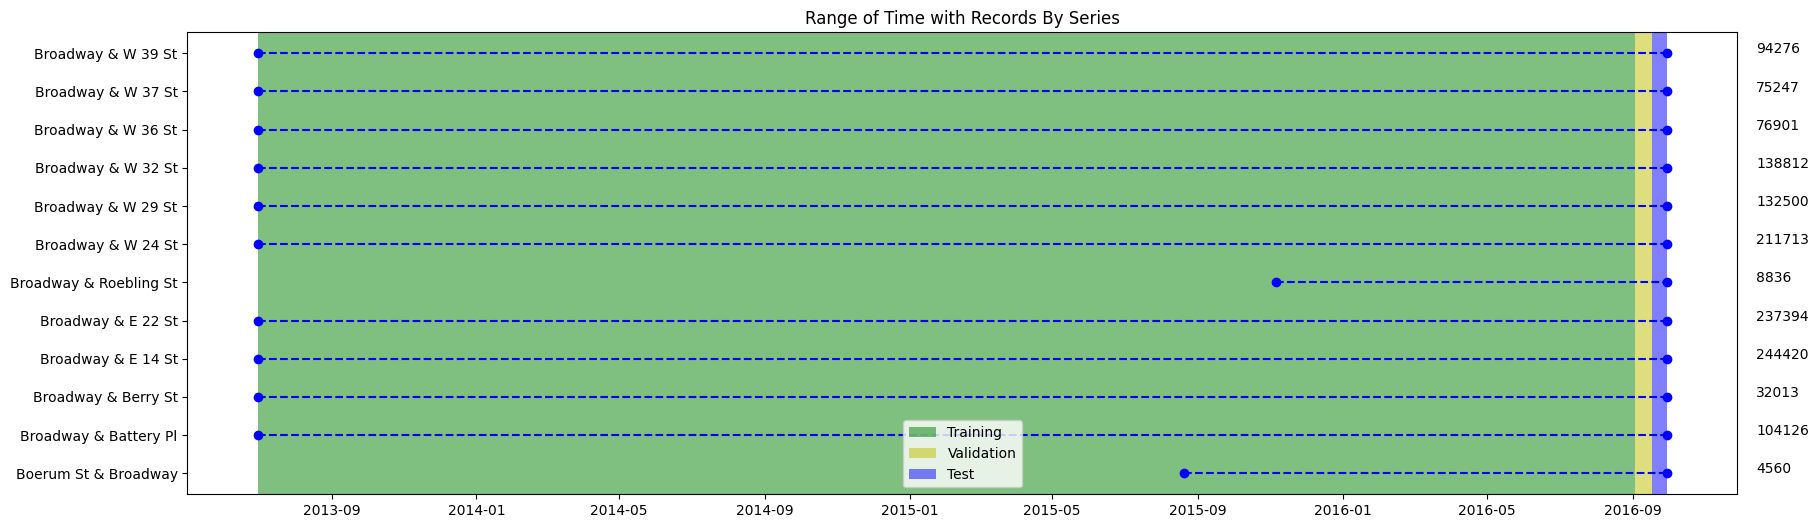

In [58]:
plt.figure(figsize=(20,6))
for i in range(viz_limit):
    x = [overview['FromDate'][i], overview['ToDate'][i]]
    y = [overview[SERIES_COLUMN][i], overview[SERIES_COLUMN][i]]
    plt.plot(x, y, 'bo', linestyle="--")
    plt.text(x[1]+timedelta(75), y[0], str(overview[TARGET_COLUMN][i]))
    plt.title('Range of Time with Records By Series')
plt.axvspan(keyDates['start_date'][0], keyDates['val_start'][0], facecolor='g', alpha = 0.5, label = 'Training')
plt.axvspan(keyDates['val_start'][0], keyDates['test_start'][0], facecolor='y', alpha = 0.5, label = 'Validation')
plt.axvspan(keyDates['test_start'][0], keyDates['end_date'][0], facecolor='b', alpha = 0.5, label = 'Test')
plt.legend(loc = 'lower center')
plt.show()

### Create BigQuery Table for Forecasting

In [59]:
query = f"""
    CREATE OR REPLACE TABLE `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_prepped` AS
    SELECT *,
       CASE
           WHEN {TIME_COLUMN} > DATE_SUB((SELECT MAX({TIME_COLUMN}) FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_source`), INTERVAL {forecast_test_length} {forecast_granularity}) THEN "TEST"
           WHEN {TIME_COLUMN} > DATE_SUB((SELECT MAX({TIME_COLUMN}) FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_source`), INTERVAL {forecast_test_length}+{forecast_val_length} {forecast_granularity}) THEN "VALIDATE"
           ELSE "TRAIN"
       END AS splits
    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_source`
"""
job = bq_client.query(query)
job.result()
(job.ended-job.started).total_seconds()

1.844

In [60]:
query = f"""
    SELECT 
        {SERIES_COLUMN},
        COUNTIF(splits='TRAIN') as TRAIN,
        COUNTIF(splits='VALIDATE') as VALIDATE,
        COUNTIF(splits='TEST') as TEST,
        sum({TARGET_COLUMN}) as {TARGET_COLUMN}
    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_prepped`
    GROUP BY {SERIES_COLUMN}
    ORDER BY {SERIES_COLUMN}
"""
splitCounts = bq_client.query(query).to_dataframe()
splitCounts.head(viz_limit)

start_station_name  TRAIN  VALIDATE  TEST  num_trips
0     Boerum St & Broadway    376        14    14       4560
1    Broadway & Battery Pl   1155        14    14     104126
2      Broadway & Berry St   1134        14    14      32013
3       Broadway & E 14 St   1155        14    14     244420
4       Broadway & E 22 St   1156        14    14     237394
5   Broadway & Roebling St    296        14    14       8836
6       Broadway & W 24 St   1150        14    14     211713
7       Broadway & W 29 St   1154        14    14     132500
8       Broadway & W 32 St   1151        14    14     138812
9       Broadway & W 36 St   1135        14    14      76901
10      Broadway & W 37 St   1134        14    14      75247
11      Broadway & W 39 St   1116        14    14      94276

In [61]:
splitCounts[['TRAIN','VALIDATE','TEST']].sum()

TRAIN       33032
VALIDATE      546
TEST          538
dtype: int64

In [62]:
splitCounts[['TRAIN','VALIDATE','TEST']].sum().sum()

34116

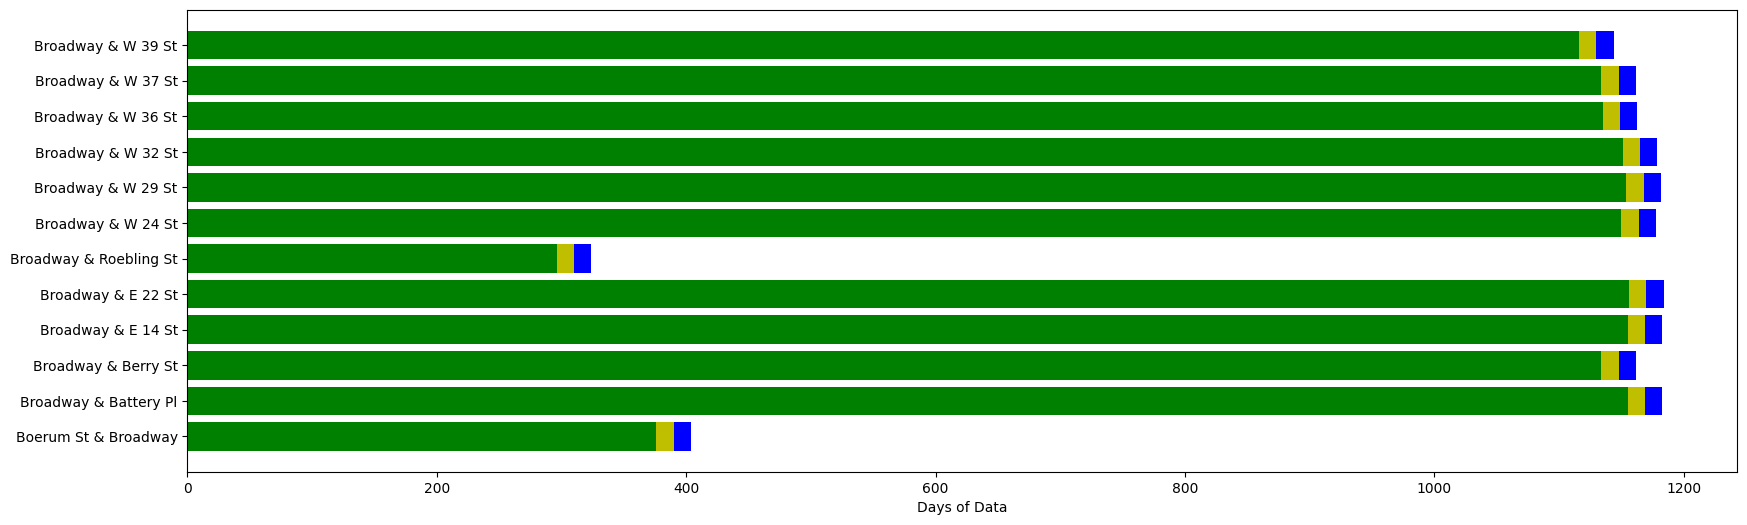

In [63]:
tempsplitCounts = splitCounts.iloc[0:viz_limit]
plt.figure(figsize=(20,6))
plt.barh(tempsplitCounts[SERIES_COLUMN], tempsplitCounts['TRAIN'], color = 'g')
plt.barh(tempsplitCounts[SERIES_COLUMN], tempsplitCounts['VALIDATE'], color = 'y', left = tempsplitCounts['TRAIN'])
plt.barh(tempsplitCounts[SERIES_COLUMN], tempsplitCounts['TEST'], color = 'b', left = tempsplitCounts['TRAIN'] + tempsplitCounts['VALIDATE'])
plt.xlabel('Days of Data')
plt.show()

### Validation Check: Extract dates for splits from source

In [64]:
query = f"""
    WITH
        SPLIT AS (
            SELECT splits, min({TIME_COLUMN}) as mindate, max({TIME_COLUMN}) as maxdate
            FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_prepped`
            GROUP BY splits
        ),
        TRAIN AS (
            SELECT mindate as start_date
            FROM SPLIT
            WHERE splits ='TRAIN'
        ),
        VAL AS (
            SELECT mindate as val_start
            FROM SPLIT
            WHERE splits = 'VALIDATE'
        ),
        TEST AS (
            SELECT mindate as test_start, maxdate as end_date
            FROM SPLIT
            WHERE splits = 'TEST'
        )
    SELECT * EXCEPT(pos) FROM
    (SELECT *, ROW_NUMBER() OVER() pos FROM TRAIN)
    JOIN (SELECT *, ROW_NUMBER() OVER() pos FROM VAL)
    USING (pos)
    JOIN (SELECT *, ROW_NUMBER() OVER() pos FROM TEST)
    USING (pos)
"""
keyDates = bq_client.query(query).to_dataframe()
keyDates

start_date   val_start  test_start    end_date
0  2013-07-01  2016-09-03  2016-09-17  2016-09-30

### check for duplicates

In [65]:
query = f"""
    WITH
        DAYS AS (
            SELECT {SERIES_COLUMN}, {TIME_COLUMN}, count(*) as records
            FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_prepped`
            GROUP BY {SERIES_COLUMN}, {TIME_COLUMN}
        )
    SELECT *
    FROM DAYS
    WHERE records > 1
"""
bq_client.query(query).to_dataframe()

Empty DataFrame
Columns: [start_station_name, starttime, records]
Index: []

In [66]:
query = f"""
    SELECT 
        {SERIES_COLUMN}, {TIME_COLUMN}, {TARGET_COLUMN}, splits,
        {', '.join(COVARIATE_COLUMNS)}
    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_prepped`
    ORDER by {SERIES_COLUMN}, {TIME_COLUMN}
"""
rawSeries = bq_client.query(query).to_dataframe()

In [69]:
rawSeries

start_station_name   starttime  num_trips splits  \
0          Boerum St & Broadway  2015-08-20          4  TRAIN   
1          Boerum St & Broadway  2015-08-21         12  TRAIN   
2          Boerum St & Broadway  2015-08-22          5  TRAIN   
3          Boerum St & Broadway  2015-08-23         18  TRAIN   
4          Boerum St & Broadway  2015-08-24          6  TRAIN   
...                         ...         ...        ...    ...   
34111  Washington Pl & Broadway  2016-09-26        233   TEST   
34112  Washington Pl & Broadway  2016-09-27        232   TEST   
34113  Washington Pl & Broadway  2016-09-28        216   TEST   
34114  Washington Pl & Broadway  2016-09-29        234   TEST   
34115  Washington Pl & Broadway  2016-09-30         75   TEST   

       avg_tripduration  pct_subscriber  ratio_gender  capacity  
0           1226.250000        0.000000      0.000000        19  
1           1073.750000        0.250000      0.333333        19  
2           1038.000000        0.200000      0.250000        19  
3            917.166667        0.388889      0.500000        19  
4           1721.000000        0.333333      0.200000        19  
...                 ...             ...           ...       ...  
34111        693.862661        0.957082      2.819672        27  
34112        664.681034        0.991379      3.296296        27  
34113        642.291667        0.972222      3.153846        27  
34114        567.700855        0.987179      3.105263        27  
34115        551.986667        0.973333      4.769231        27  

[34116 rows x 8 columns]

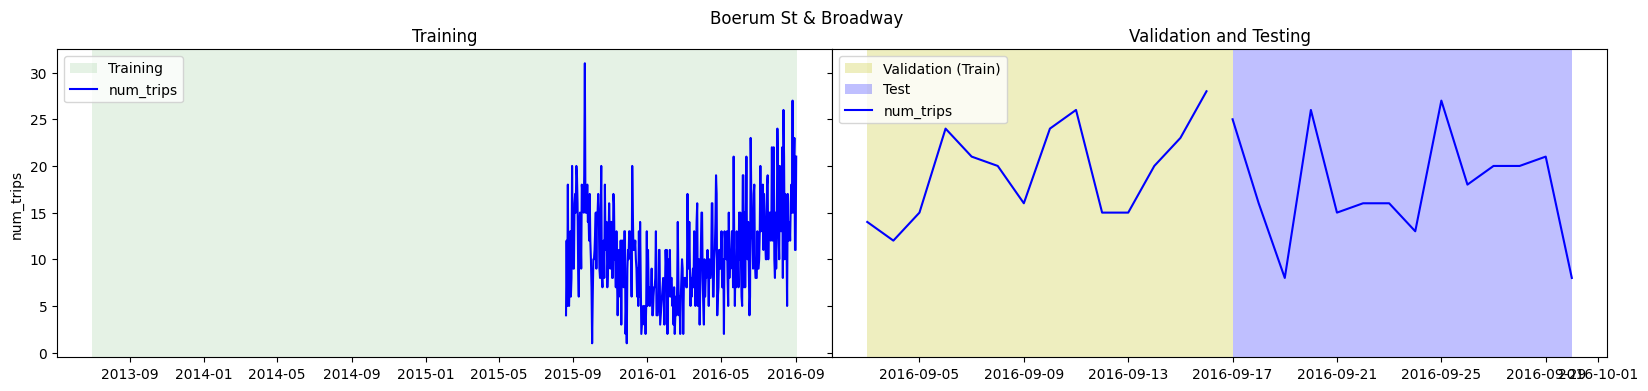

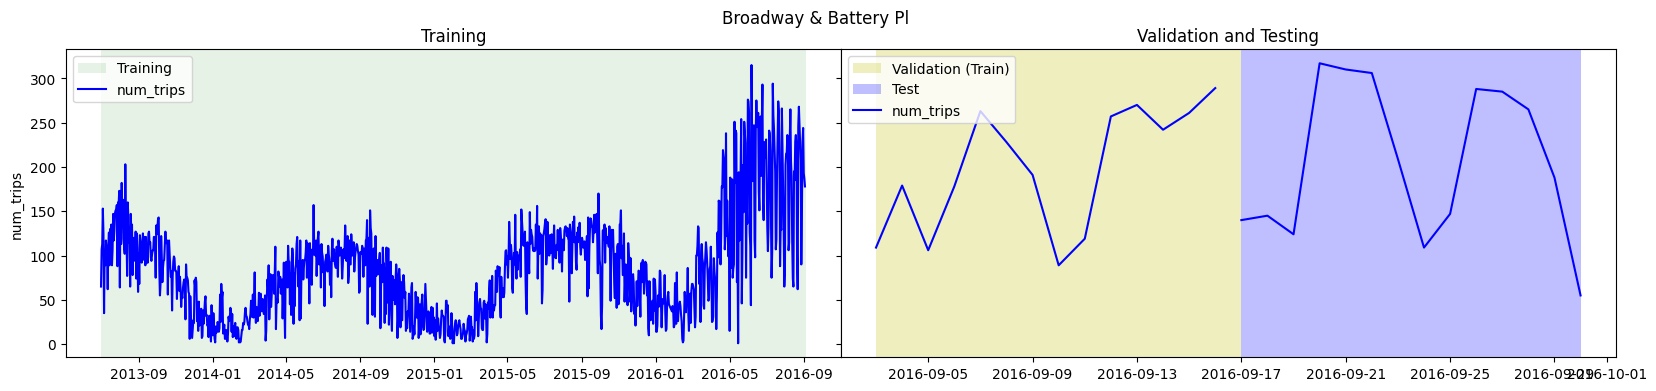

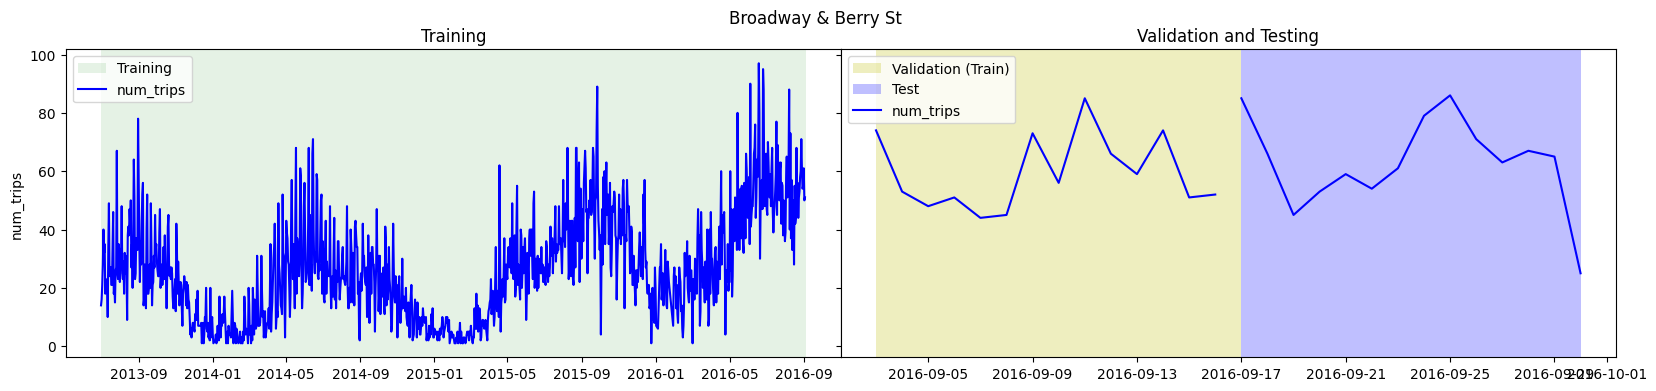

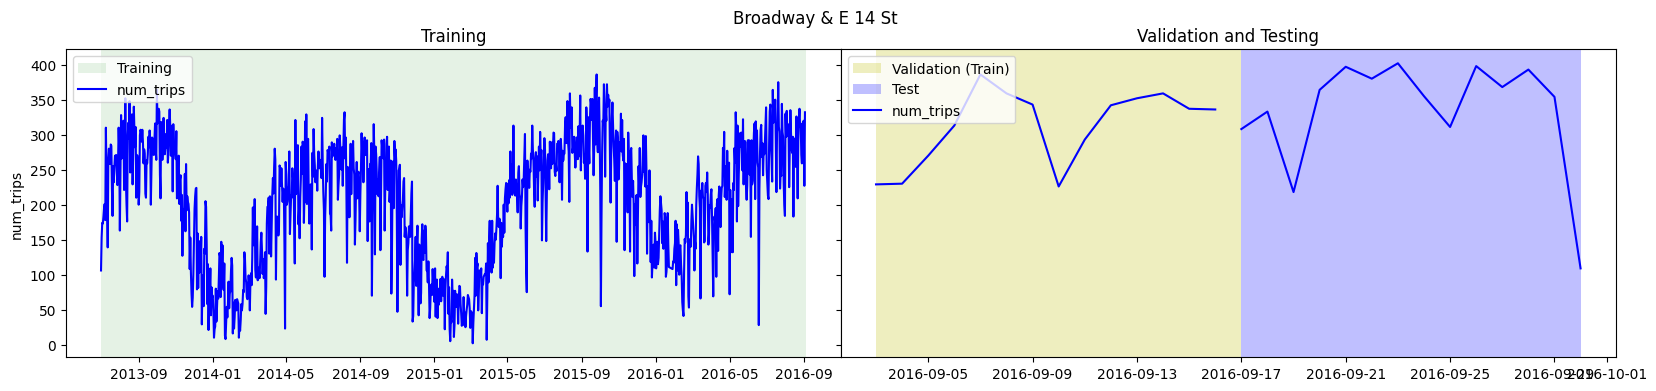

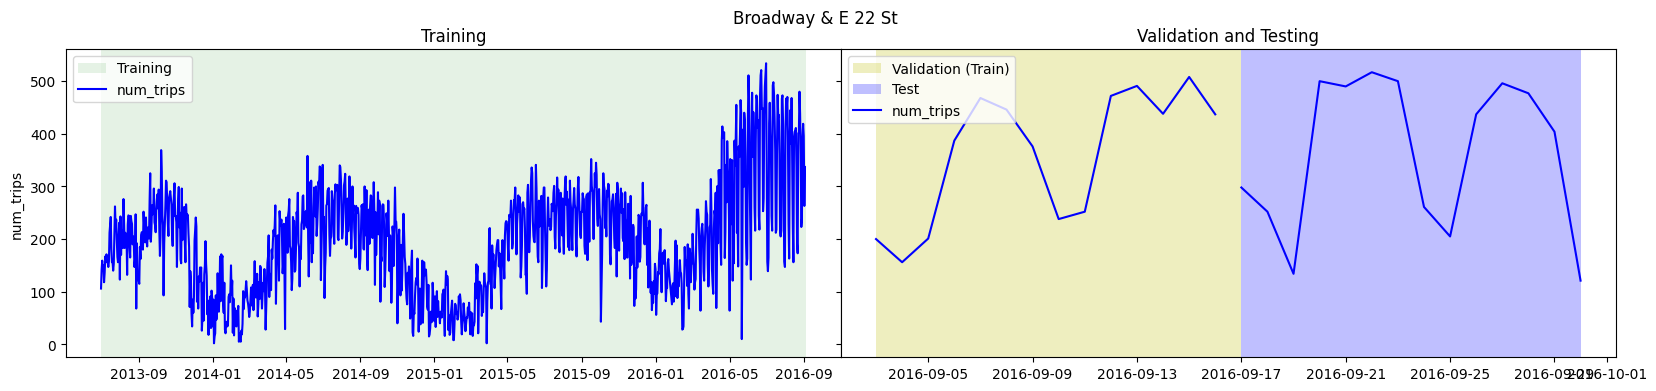

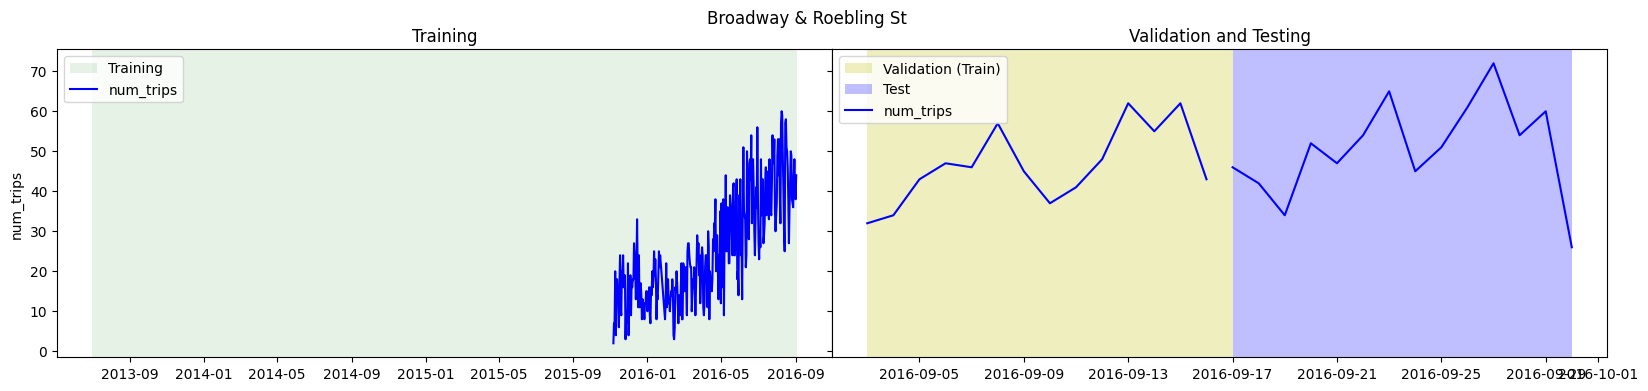

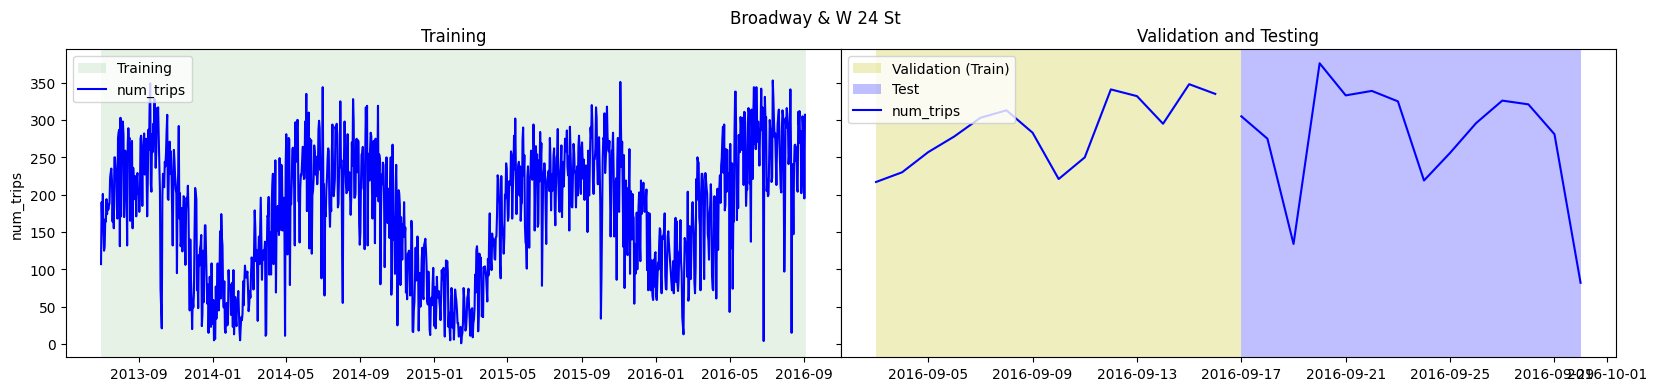

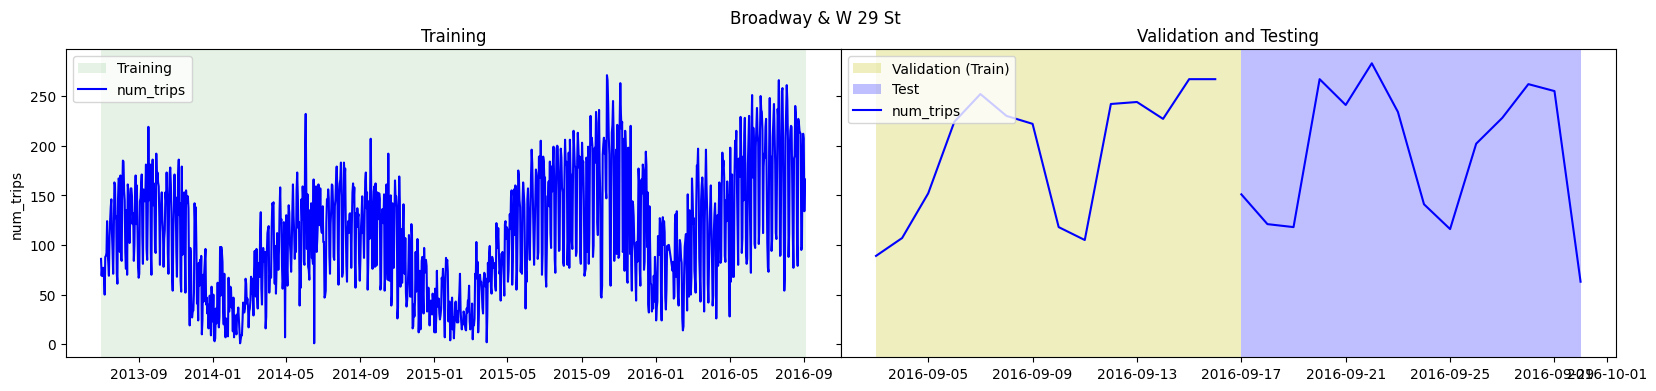

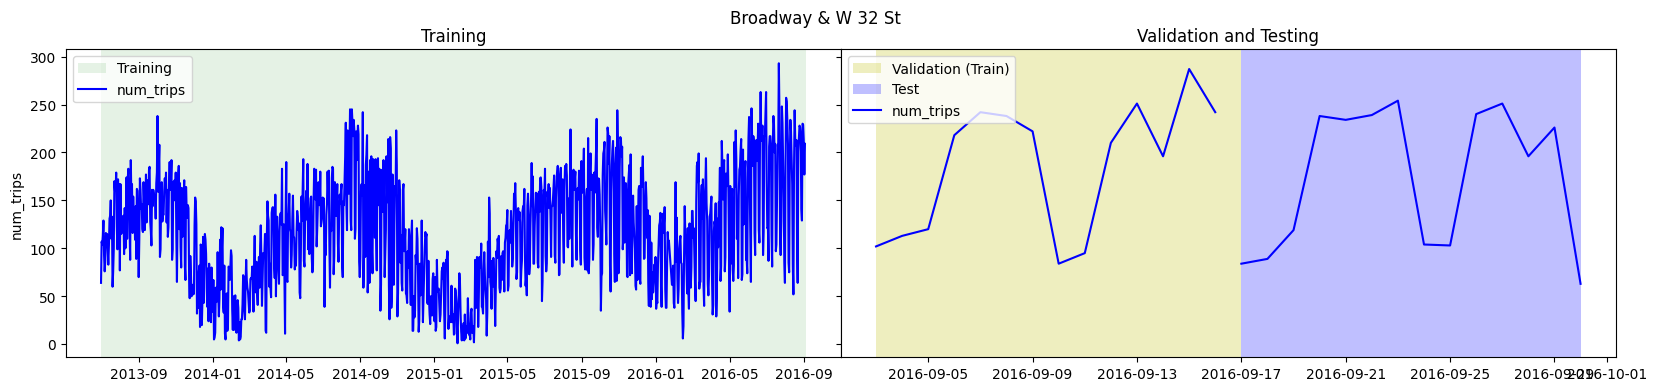

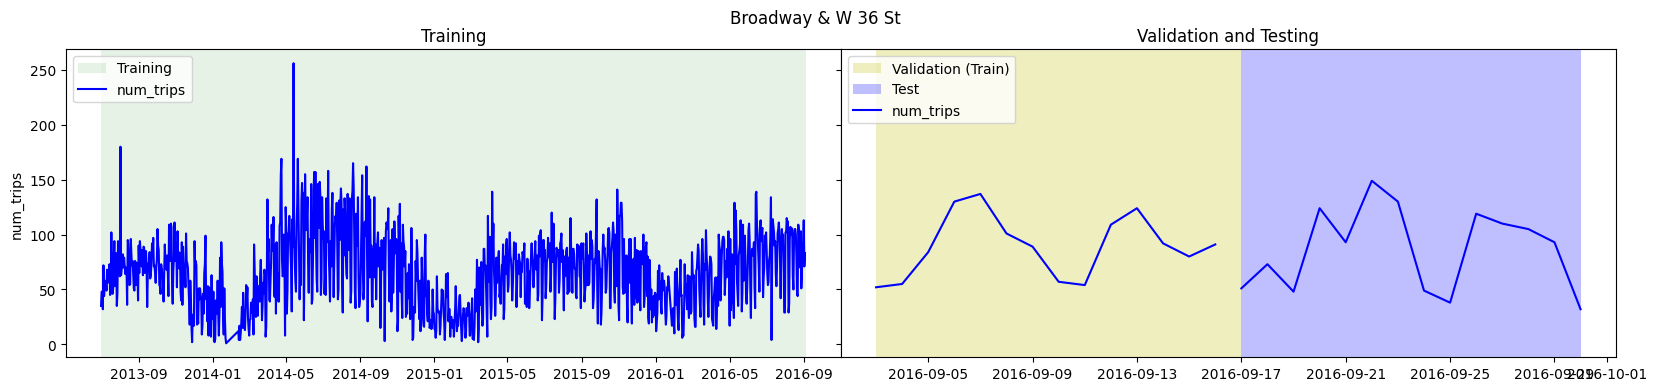

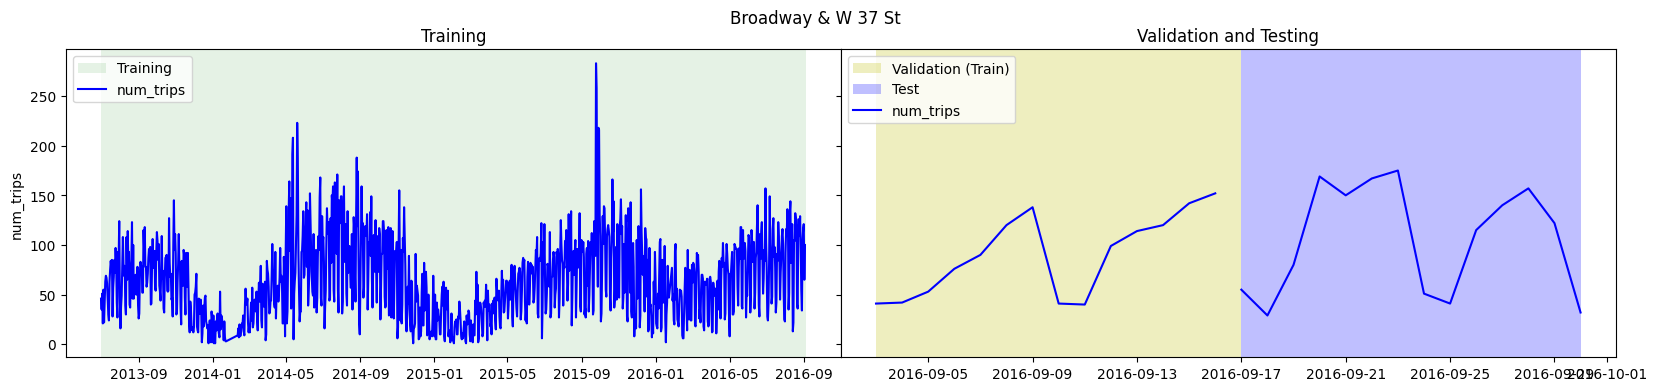

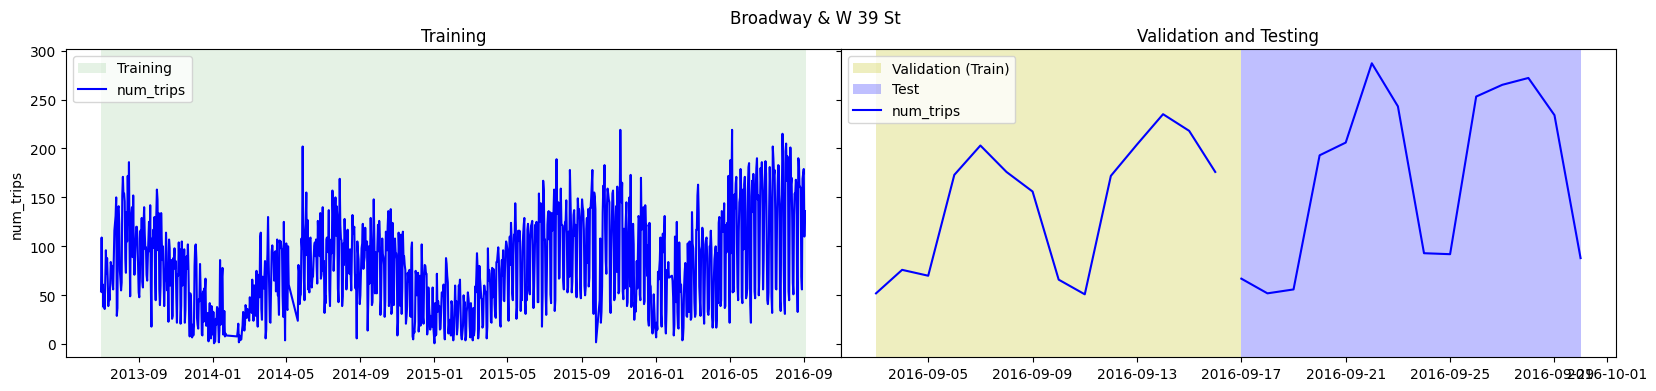

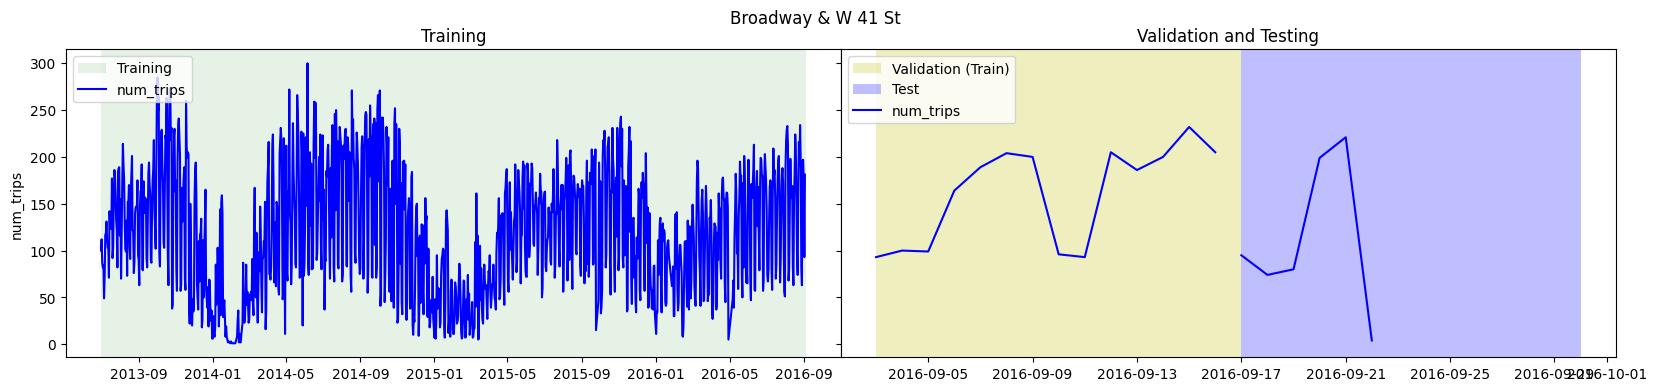

In [67]:
series = rawSeries[SERIES_COLUMN].unique().tolist()
for s, st in enumerate(series):
    if s <= viz_limit:
        # setup plot area
        fig, axes = plt.subplots(1, 2, figsize=(20, 4), sharex=False, sharey=True)
        fig.subplots_adjust(wspace=0)

        # data
        traindf = rawSeries[(rawSeries[SERIES_COLUMN] == st) & (rawSeries['splits'] == 'TRAIN')]
        valdf = rawSeries[(rawSeries[SERIES_COLUMN] == st) & (rawSeries['splits'] == 'VALIDATE')]
        testdf = rawSeries[(rawSeries[SERIES_COLUMN] == st) & (rawSeries['splits'] == 'TEST')]

        # regions
        axes[0].axvspan(keyDates['start_date'][0], keyDates['val_start'][0], facecolor='g', alpha = 0.1, label = 'Training')
        axes[1].axvspan(keyDates['val_start'][0], keyDates['test_start'][0], facecolor='y', alpha = 0.25, label = 'Validation (Train)')
        axes[1].axvspan(keyDates['test_start'][0], keyDates['end_date'][0], facecolor='b', alpha = 0.25, label = 'Test')

        # lines and dots
        axes[0].plot(traindf[TIME_COLUMN], traindf[TARGET_COLUMN], color = 'b', label = f'{TARGET_COLUMN}')
        axes[1].plot(valdf[TIME_COLUMN], valdf[TARGET_COLUMN], color = 'b', label = f'{TARGET_COLUMN}')
        axes[1].plot(testdf[TIME_COLUMN], testdf[TARGET_COLUMN], color = 'b')

        # labels
        axes[0].set_ylabel(TARGET_COLUMN)
        axes[0].set_title('Training')
        axes[1].set_title('Validation and Testing')
        axes[1].legend(loc = 'upper left')
        axes[0].legend(loc = 'upper left')
        plt.suptitle(st)

        # display result
        plt.show()

### overlay covariates

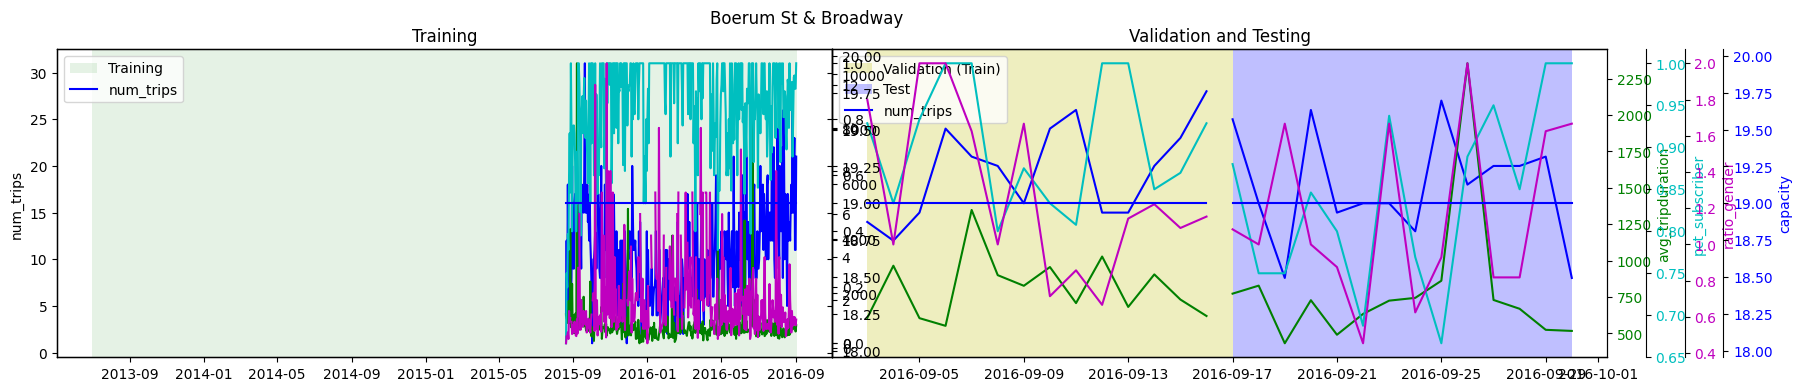

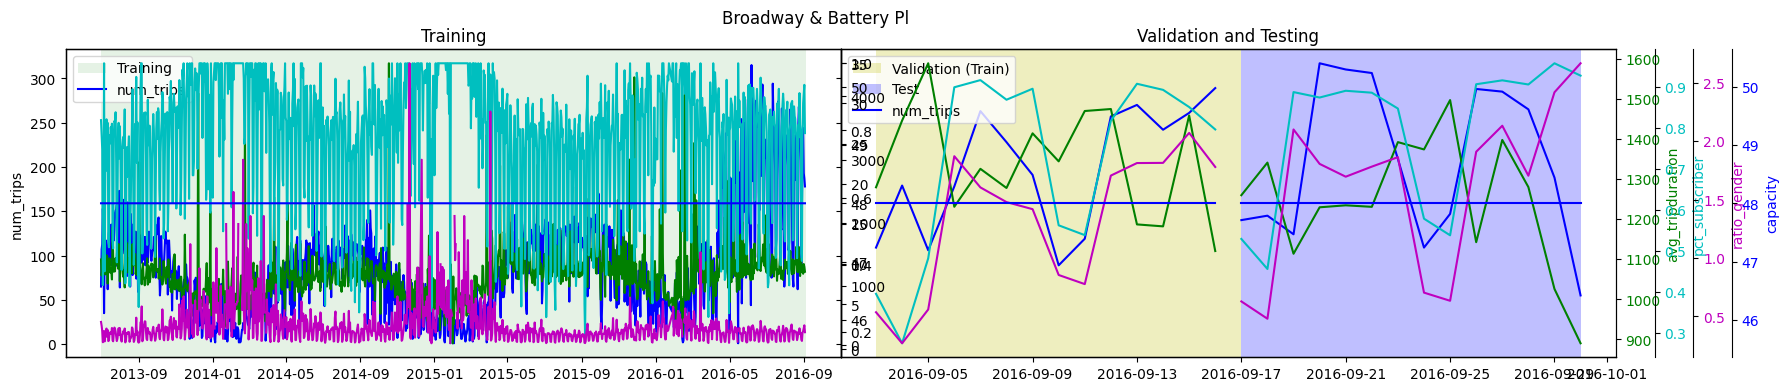

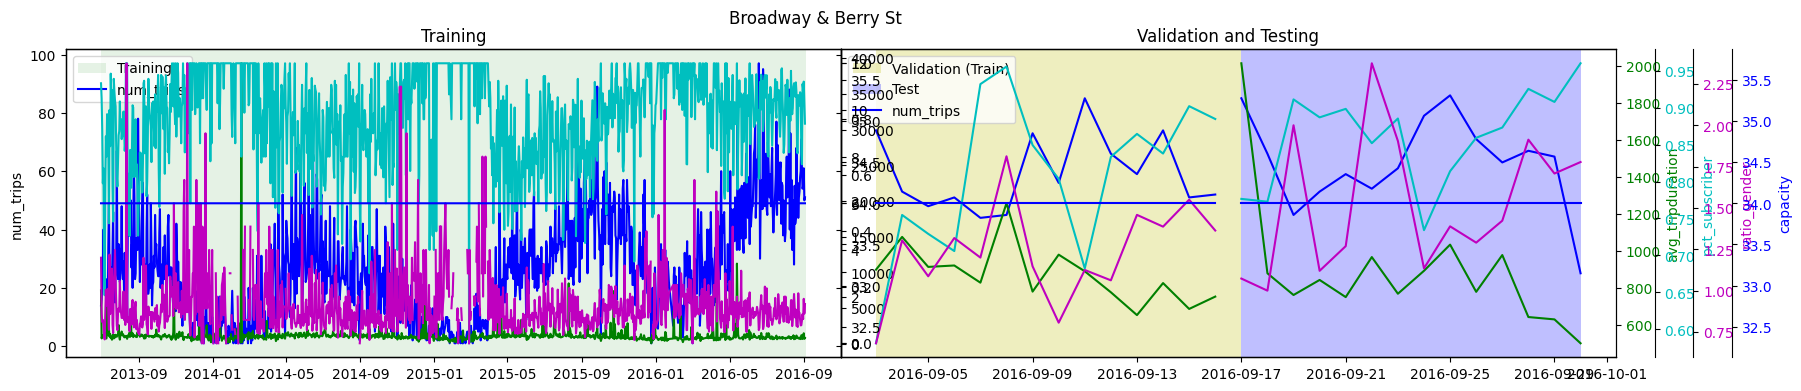

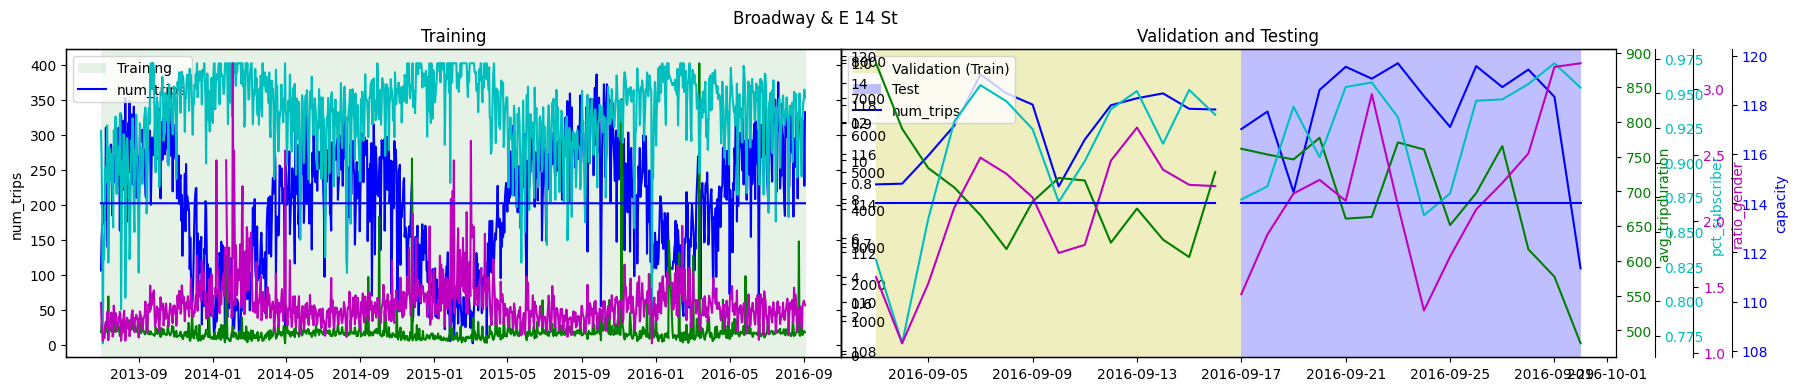

TypeError: float() argument must be a string or a number, not 'NAType'

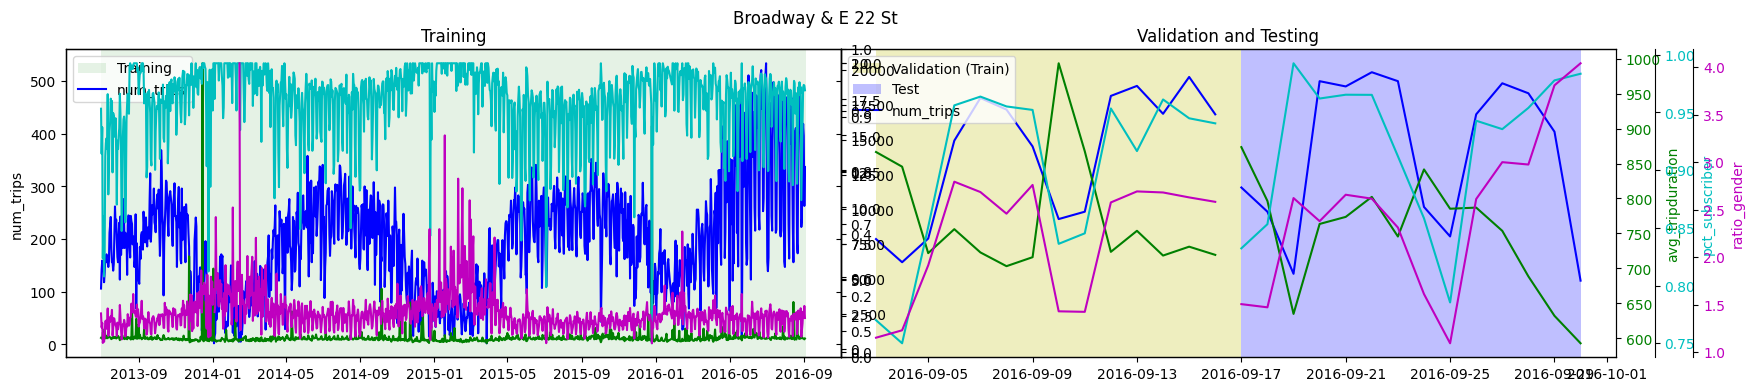

In [68]:
series = rawSeries[SERIES_COLUMN].unique().tolist()
for s, st in enumerate(series):
    if s <= viz_limit:
        # setup plot area
        fig, axes = plt.subplots(1, 2, figsize=(20, 4), sharex=False, sharey=True)
        fig.subplots_adjust(wspace=0)

        # data
        traindf = rawSeries[(rawSeries[SERIES_COLUMN] == st) & (rawSeries['splits'] == 'TRAIN')]
        valdf = rawSeries[(rawSeries[SERIES_COLUMN] == st) & (rawSeries['splits'] == 'VALIDATE')]
        testdf = rawSeries[(rawSeries[SERIES_COLUMN] == st) & (rawSeries['splits'] == 'TEST')]

        # regions
        axes[0].axvspan(keyDates['start_date'][0], keyDates['val_start'][0], facecolor='g', alpha = 0.1, label = 'Training')
        axes[1].axvspan(keyDates['val_start'][0], keyDates['test_start'][0], facecolor='y', alpha = 0.25, label = 'Validation (Train)')
        axes[1].axvspan(keyDates['test_start'][0], keyDates['end_date'][0], facecolor='b', alpha = 0.25, label = 'Test')

        # lines and dots
        axes[0].plot(traindf[TIME_COLUMN], traindf[TARGET_COLUMN], color = 'b', label = f'{TARGET_COLUMN}')
        axes[1].plot(valdf[TIME_COLUMN], valdf[TARGET_COLUMN], color = 'b', label = f'{TARGET_COLUMN}')
        axes[1].plot(testdf[TIME_COLUMN], testdf[TARGET_COLUMN], color = 'b')

        # labels
        axes[0].set_ylabel(TARGET_COLUMN)
        axes[0].set_title('Training')
        axes[1].set_title('Validation and Testing')
        axes[1].legend(loc = 'upper left')
        axes[0].legend(loc = 'upper left')
        plt.suptitle(st)

        # overaly covariates (up to 5):
        for c, cov in enumerate(COVARIATE_COLUMNS):
            colors = ['g','c','m','b','r']
            if c<5:
                
                twin = axes[0].twinx()
                twin.plot(traindf[TIME_COLUMN], traindf[cov], color = colors[c], label = f'{cov}')
                
                twin = axes[1].twinx()
                twin.set_ylabel(cov, color = colors[c])
                twin.tick_params(axis = 'y', labelcolor = colors[c])
                twin.spines.right.set_position(("axes", 1+.05*c))
                twin.plot(valdf[TIME_COLUMN], valdf[cov], color = colors[c], label = f'{cov}')
                twin.plot(testdf[TIME_COLUMN], testdf[cov], color = colors[c], label = f'{cov}')
        
        # display result
        plt.show()